# Task 2: Model Implementation:
 
1. Define and justify a clinically meaningful approach to modelling time to death. 
2. Cohort Construction: Build your patient-level cohort from admissions.csv, patients.csv, and optionally ICU records from icustays.csv. 
3. Feature Engineering: Generate features using structured data (demographics, admissions, diagnoses, medications, procedures, etc.) from other files. 
4. Modelling Approaches: Implement different models. Explain and justify your modelling approach. 
5. Bonus: Explore whether it is possible to identify or infer the cause of death.

# Subtask 1: Defining time to death:


Proposed Definition: Time from Hospital Admission to Death for the Final Admission

1. Starting Point: The timestamp of admission for the final hospital stay (admittime from the admissions table for the specific hadm_id during which the patient died).

2. Endpoint: The timestamp of death recorded during that same final hospital admission (deathtime from the admissions table for that hadm_id).

3. Calculation:
`Time to Death` = `deathtime` - `admittime` (for the final admission where hospital_expire_flag = 1)

## Significance:
1. **Relevance**: High! This aligns perfectly with assessing the severity and expected course of the illness episode that ultimately led to death.
2. **Interpretability**: High!, For a patient admitted in this critical state, how long did they survive within this hospital stay? This answers is a direct, meaningful question.
3. **Actionability**: Moderate: Predicting time of death can directly inform clinical decisions during that admission (e.g., goals of care discussions, resource intensity, palliative care involvement).

Import libraries

In [1]:
%load_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

from loguru import logger

# Set pandas columns width to 100
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings("ignore")

# Subtask 2 - Cohort Creation:
Cohort Construction: Build your patient-level cohort from admissions.csv, patients.csv, and optionally ICU records from icustays.csv. 

**Objective:**
1. To develop a regression model predicting time to death from the start of a patient’s final hospital admission.


**Cohort Inclusion Criteria**
1. Adult patients (≥18 years old).
2. Patients with at least one hospital admission that eventually die (hadm_id) recorded in the MIMIC-IV database.
3. The final hospital admission (i.e., the last hadm_id) was selected for each patient.
4. Only patients with documented in-hospital death during this final admission were labeled as deceased (hospital_expire_flag = 1) for time-to-event calculation.
5. Patients with missing admittime or deathtime were excluded.

In [2]:
from main import run_cohort_preparation_pipeline

cohort_df, time_to_death_df = run_cohort_preparation_pipeline()

2025-04-23 04:26:56.871 | INFO     | main:run_cohort_preparation_pipeline:24 - -------------------------- Running cohort preparation pipeline...
2025-04-23 04:26:56.953 | INFO     | assessment.datasets:load_admissions_data:18 - Loading admissions data from /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/raw/mimiciv/2.1/hosp/admissions.csv
2025-04-23 04:26:58.778 | INFO     | assessment.datasets:load_admissions_data:20 - Loaded 431088 rows of admissions data.
2025-04-23 04:26:58.779 | INFO     | assessment.datasets:load_patients_data:28 - Loading patients data from /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/raw/mimiciv/2.1/hosp/patients.csv
2025-04-23 04:26:58.996 | INFO     | assessment.datasets:load_patients_data:30 - Loaded 299777 rows of patients data.
2025-04-23 04:26:58.996 | INFO     | assessment.features_hosp:prepare_cohort:104 - Loaded 431088 rows of admissions data.
2025-04-23 04:26:58.996 | INFO     | assessment.features_hosp:prepare_cohort:105 - Loaded 299777 ro

In [3]:
cohort_df

subject_id   hadm_id           admittime           dischtime  age  \
64        10001884  21268656 2125-10-18 16:50:00 2125-10-20 15:15:00   68   
75        10001884  26679629 2125-10-26 20:32:00 2125-10-27 16:28:00   68   
67        10001884  23594368 2125-11-30 16:02:00 2125-12-03 14:44:00   68   
65        10001884  21577720 2125-12-26 17:06:00 2125-12-27 16:52:00   68   
68        10001884  24325811 2126-11-04 00:50:00 2126-11-04 12:49:00   68   
...            ...       ...                 ...                 ...  ...   
430792    19996061  26115327 2118-07-25 17:55:00 2118-07-29 13:00:00   76   
430902    19998843  24842066 2187-02-05 09:27:00 2187-02-08 17:28:00   45   
430915    19999297  21439025 2162-08-14 23:55:00 2162-08-23 04:16:00   42   
430951    19999840  26071774 2164-07-25 00:27:00 2164-07-28 12:15:00   58   
430950    19999840  21033226 2164-09-10 13:47:00 2164-09-17 13:42:00   58   

       gender                     race insurance  label                  dod  \
64          F   BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
75          F   BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
67          F   BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
65          F   BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
68          F   BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
...       ...                      ...       ...    ...                  ...   
430792      M                    WHITE     Other      1  2118-07-29 00:00:00   
430902      M                  UNKNOWN     Other      1  2187-02-08 00:00:00   
430915      M  MULTIPLE RACE/ETHNICITY     Other      1  2162-08-23 00:00:00   
430951      M                    WHITE     Other      0  2164-09-17 00:00:00   
430950      M                    WHITE     Other      1  2164-09-17 00:00:00   

        time_to_death     admission_type admission_location discharge_location  
64        1919.298611           EW EMER.     EMERGENCY ROOM               HOME  
75        1911.144444           EW EMER.     EMERGENCY ROOM               HOME  
67        1876.331944           EW EMER.     EMERGENCY ROOM   HOME HEALTH CARE  
65        1850.287500     EU OBSERVATION     EMERGENCY ROOM                  0  
68        1537.965278     EU OBSERVATION     EMERGENCY ROOM                  0  
...               ...                ...                ...                ...  
430792       3.253472           EW EMER.     EMERGENCY ROOM               DIED  
430902       2.606250           EW EMER.     EMERGENCY ROOM               DIED  
430915       8.003472  OBSERVATION ADMIT     EMERGENCY ROOM               DIED  
430951      53.981250           EW EMER.     EMERGENCY ROOM               HOME  
430950       6.425694           EW EMER.     EMERGENCY ROOM               DIED  

[31043 rows x 14 columns]

In [4]:
test_subject_id = 10001884
# test_subject_id = cohort_df["subject_id"].sample(1).iloc[0]

cohort_df[cohort_df["subject_id"] == test_subject_id].sort_values("admittime")

subject_id   hadm_id           admittime           dischtime  age gender  \
64    10001884  21268656 2125-10-18 16:50:00 2125-10-20 15:15:00   68      F   
75    10001884  26679629 2125-10-26 20:32:00 2125-10-27 16:28:00   68      F   
67    10001884  23594368 2125-11-30 16:02:00 2125-12-03 14:44:00   68      F   
65    10001884  21577720 2125-12-26 17:06:00 2125-12-27 16:52:00   68      F   
68    10001884  24325811 2126-11-04 00:50:00 2126-11-04 12:49:00   68      F   
76    10001884  26812645 2127-07-24 18:06:00 2127-07-25 17:41:00   68      F   
79    10001884  27765344 2127-12-11 18:06:00 2127-12-12 13:46:00   68      F   
71    10001884  25758848 2128-07-15 18:44:00 2128-07-17 13:31:00   68      F   
83    10001884  29675586 2130-04-08 22:06:00 2130-04-09 14:30:00   68      F   
72    10001884  26170293 2130-04-15 21:10:00 2130-04-19 16:00:00   68      F   
77    10001884  27016754 2130-06-23 22:14:00 2130-06-24 11:07:00   68      F   
74    10001884  26202981 2130-08-21 15:26:00 2130-08-23 16:40:00   68      F   
63    10001884  21192799 2130-10-05 20:04:00 2130-10-06 15:05:00   68      F   
84    10001884  29678536 2130-10-08 19:03:00 2130-10-12 19:05:00   68      F   
66    10001884  22532141 2130-10-14 00:58:00 2130-10-14 13:57:00   68      F   
80    10001884  28475784 2130-10-19 16:20:00 2130-10-22 15:13:00   68      F   
82    10001884  28669374 2130-11-19 18:35:00 2130-11-20 10:46:00   68      F   
81    10001884  28664981 2130-11-28 16:47:00 2130-11-30 15:34:00   68      F   
70    10001884  24962904 2130-12-06 20:14:00 2130-12-08 18:00:00   68      F   
78    10001884  27507515 2130-12-23 19:32:00 2130-12-24 16:42:00   68      F   
69    10001884  24746267 2130-12-27 21:23:00 2130-12-30 15:33:00   68      F   
73    10001884  26184834 2131-01-07 20:39:00 2131-01-20 05:15:00   68      F   

                      race insurance  label                  dod  \
64  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
75  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
67  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
65  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
68  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
76  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
79  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
71  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
83  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
72  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
77  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
74  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
63  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
84  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
66  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
80  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
82  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
81  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
70  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
78  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
69  BLACK/AFRICAN AMERICAN  Medicare      0  2131-01-20 00:00:00   
73  BLACK/AFRICAN AMERICAN  Medicare      1  2131-01-20 00:00:00   

    time_to_death      admission_type  admission_location  \
64    1919.298611            EW EMER.      EMERGENCY ROOM   
75    1911.144444            EW EMER.      EMERGENCY ROOM   
67    1876.331944            EW EMER.      EMERGENCY ROOM   
65    1850.287500      EU OBSERVATION      EMERGENCY ROOM   
68    1537.965278      EU OBSERVATION      EMERGENCY ROOM   
76    1275.245833      EU OBSERVATION      EMERGENCY ROOM   
79    1135.245833  DIRECT OBSERVATION  PHYSICIAN REFERRAL   
71     918.219444      EU OBSERVATION      EMERGENCY ROOM   
83     286.079167      EU OBSERVATION      EMERGE

## Insights:
In the above dataframe, we see that the last admission is where the patient dies.

In [5]:
time_to_death_df

subject_id   hadm_id           admittime           dischtime  age  \
73        10001884  26184834 2131-01-07 20:39:00 2131-01-20 05:15:00   68   
102       10002155  20345487 2131-03-09 20:33:00 2131-03-10 01:55:00   80   
197       10003400  23559586 2137-08-04 00:07:00 2137-09-02 17:05:00   72   
236       10004401  25777141 2144-06-05 19:45:00 2144-06-18 21:30:00   82   
260       10004720  22081550 2186-11-12 18:01:00 2186-11-17 18:30:00   61   
...            ...       ...                 ...                 ...  ...   
430764    19995127  27369164 2138-06-06 18:00:00 2138-06-12 01:48:00   78   
430792    19996061  26115327 2118-07-25 17:55:00 2118-07-29 13:00:00   76   
430902    19998843  24842066 2187-02-05 09:27:00 2187-02-08 17:28:00   45   
430915    19999297  21439025 2162-08-14 23:55:00 2162-08-23 04:16:00   42   
430950    19999840  21033226 2164-09-10 13:47:00 2164-09-17 13:42:00   58   

       gender                     race insurance  label                  dod  \
73          F   BLACK/AFRICAN AMERICAN  Medicare      1  2131-01-20 00:00:00   
102         F                    WHITE     Other      1  2131-03-10 00:00:00   
197         F   BLACK/AFRICAN AMERICAN  Medicare      1  2137-09-02 00:00:00   
236         M                    WHITE  Medicare      1  2144-06-18 00:00:00   
260         M                    WHITE  Medicare      1  2186-11-17 00:00:00   
...       ...                      ...       ...    ...                  ...   
430764      M   BLACK/AFRICAN AMERICAN  Medicare      1  2138-06-12 00:00:00   
430792      M                    WHITE     Other      1  2118-07-29 00:00:00   
430902      M                  UNKNOWN     Other      1  2187-02-08 00:00:00   
430915      M  MULTIPLE RACE/ETHNICITY     Other      1  2162-08-23 00:00:00   
430950      M                    WHITE     Other      1  2164-09-17 00:00:00   

        time_to_death     admission_type         admission_location  \
73          12.139583  OBSERVATION ADMIT             EMERGENCY ROOM   
102          0.143750           EW EMER.             EMERGENCY ROOM   
197         28.995139             URGENT     TRANSFER FROM HOSPITAL   
236         12.177083           EW EMER.             EMERGENCY ROOM   
260          4.249306           EW EMER.  INFORMATION NOT AVAILABLE   
...               ...                ...                        ...   
430764       5.250000           EW EMER.             EMERGENCY ROOM   
430792       3.253472           EW EMER.             EMERGENCY ROOM   
430902       2.606250           EW EMER.             EMERGENCY ROOM   
430915       8.003472  OBSERVATION ADMIT             EMERGENCY ROOM   
430950       6.425694           EW EMER.             EMERGENCY ROOM   

       discharge_location  
73                   DIED  
102                  DIED  
197                  DIED  
236                  DIED  
260                  DIED  
...                   ...  
430764               DIED  
430792               DIED  
430902               DIED  
430915               DIED  
430950               DIED  

[8316 rows x 14 columns]

In [6]:
time_to_death_df[time_to_death_df["subject_id"] == test_subject_id]

subject_id   hadm_id           admittime           dischtime  age gender  \
73    10001884  26184834 2131-01-07 20:39:00 2131-01-20 05:15:00   68      F   

                      race insurance  label                  dod  \
73  BLACK/AFRICAN AMERICAN  Medicare      1  2131-01-20 00:00:00   

    time_to_death     admission_type admission_location discharge_location  
73      12.139583  OBSERVATION ADMIT     EMERGENCY ROOM               DIED

# Subtask 3: Feature Engineering

I have incorporated longitudinal patient history by extracting features from prior hospital and ICU admissions before the final admission where the time-to-death prediction is anchored.

Clinical history is a strong determinant of patient outcomes. Prior admissions contain valuable insights into:

1. Chronic conditions
2. Historical lab abnormalities
3. Patterns of healthcare utilization

Method

1. For each patient, we anchor the prediction at their final hospital admission (hadm_id_final).
2. We retrieve all previous admissions (i.e., hadm_id values occurring before the admittime of hadm_id_final).
Features derived from these historical admissions include:
    
    A. Diagnosis and procedure codes: Used to compute comorbidity scores (Charlson, Elixhauser), flags for chronic conditions (e.g., stroke, cancer, liver disease).
    
    B. Lab values and trends: Temporal summaries such as averages, max/min values, and standard deviations across different time windows (e.g., 7, 30, 90, 180, 365 days before final admission).
    
    c. Utilization patterns: Number of hospital in specific windows.

Temporal Validity:

To avoid data leakage: Only data available before the final admission was used to engineer features. Time windows are anchored relative to the admittime of the final hospital stay.

In [ ]:
from main import run_feature_creation_pipeline

df = run_feature_creation_pipeline(cohort_df = cohort_df)

2025-04-23 04:27:10.013 | INFO     | main:run_feature_creation_pipeline:53 - ------------------------------------------------------
2025-04-23 04:27:10.014 | INFO     | main:run_feature_creation_pipeline:54 -                 FEATURE CREATION                      
2025-04-23 04:27:10.014 | INFO     | main:run_feature_creation_pipeline:55 - ------------------------------------------------------
2025-04-23 04:27:10.014 | INFO     | main:run_feature_creation_pipeline:57 - Creating features for 31043 cohort entries
2025-04-23 04:27:10.014 | INFO     | main:run_feature_creation_pipeline:59 - ----------------- STEP I - DIAGNOSIS FEATURES -----------------
2025-04-23 04:27:10.014 | INFO     | main:run_feature_creation_pipeline:61 - Creating diagnosis features for 31043 cohort entries.
2025-04-23 04:27:10.014 | INFO     | assessment.datasets:load_diagnoses_data:48 - Loading diagnoses data from /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/raw/mimiciv/2.1/hosp/diagnoses_icd.csv
2025-04-23 

100%|██████████| 8311/8311 [01:42<00:00, 80.76it/s] 


2025-04-23 04:28:56.140 | INFO     | main:run_feature_creation_pipeline:64 - Diagnosis features created for 4723 cohort entries.
2025-04-23 04:28:56.235 | INFO     | main:run_feature_creation_pipeline:68 - Diagnosis features interim data saved to /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/processed/hosp/diagnosis_feat_df.csv
2025-04-23 04:28:56.235 | INFO     | main:run_feature_creation_pipeline:71 - ----------------- STEP II - PROCEDURE FEATURES -----------------
2025-04-23 04:28:56.235 | INFO     | main:run_feature_creation_pipeline:73 - Creating procedure features for 31043 cohort entries.
2025-04-23 04:28:56.235 | INFO     | assessment.datasets:load_procedures_data:57 - Loading procedures data from /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/raw/mimiciv/2.1/hosp/procedures_icd.csv
2025-04-23 04:28:56.858 | INFO     | assessment.datasets:load_procedures_data:59 - Loaded 668993 rows of procedures data.


100%|██████████| 8311/8311 [00:13<00:00, 603.77it/s]


2025-04-23 04:29:10.685 | INFO     | main:run_feature_creation_pipeline:76 - Procedure features created for 4723 cohort entries.
2025-04-23 04:29:10.705 | INFO     | main:run_feature_creation_pipeline:80 - Procedure features interim data saved to /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/processed/hosp/procedures_feat_df.csv
2025-04-23 04:29:10.706 | INFO     | main:run_feature_creation_pipeline:82 - ----------------- STEP III - MEDICATION FEATURES -----------------
2025-04-23 04:29:10.706 | INFO     | main:run_feature_creation_pipeline:83 - Creating medication features for 31043 cohort entries.
2025-04-23 04:29:10.706 | INFO     | assessment.datasets:load_prescriptions_data:84 - Loading prescriptions data from /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/raw/mimiciv/2.1/hosp/prescriptions.csv
2025-04-23 04:30:26.298 | INFO     | assessment.datasets:load_prescriptions_data:86 - Loaded 15399811 rows of prescriptions data.


100%|██████████| 8311/8311 [02:28<00:00, 55.78it/s]


2025-04-23 04:33:06.664 | INFO     | main:run_feature_creation_pipeline:86 - Medication features created for 8311 cohort entries.
2025-04-23 04:33:06.720 | INFO     | main:run_feature_creation_pipeline:90 - Medication features interim data saved to /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/processed/hosp/prescriptions_feat_df.csv
2025-04-23 04:33:06.721 | INFO     | main:run_feature_creation_pipeline:95 - Creating lab tests features for 31043 cohort entries.
2025-04-23 04:33:06.721 | INFO     | assessment.datasets:load_d_labitems_data:75 - Loading d_labitems data from /mnt/d/Projects/Hurdle/Time_to_death_modelling/data/raw/mimiciv/2.1/hosp/d_labitems.csv
2025-04-23 04:33:06.744 | INFO     | assessment.datasets:load_d_labitems_data:77 - Loaded 1623 rows of d_labitems data.
2025-04-23 04:33:06.744 | INFO     | assessment.hosp_labevents:identify_itemids_from_d_labelitems:23 - Loading d_labitems data
2025-04-23 04:33:06.744 | INFO     | assessment.hosp_labevents:identify_itemids_

Processing Chunks:  88%|████████▊ | 1181/1340 [06:15<00:50,  3.14it/s]


2025-04-23 04:39:30.303 | INFO     | assessment.hosp_labevents:create_labsevents_features_chunked:118 - Aggregating lab events data...
2025-04-23 04:39:30.304 | INFO     | assessment.hosp_labevents:create_labsevents_features_chunked:119 - Number of subjects whose lab events were aggregated: 7297
2025-04-23 04:39:30.304 | INFO     | assessment.hosp_labevents:create_labsevents_features_chunked:120 - Number of subjects with last lab values: 7297
2025-04-23 04:39:30.304 | INFO     | assessment.hosp_labevents:create_labsevents_features_chunked:121 - Number of subjects with abnormal counts: 7201
2025-04-23 04:39:30.304 | INFO     | assessment.hosp_labevents:create_labsevents_features_chunked:122 - Number of subjects in cohort: 8311
2025-04-23 04:39:33.272 | INFO     | main:run_feature_creation_pipeline:97 - Lab tests features created for 8311 cohort entries.
2025-04-23 04:39:33.867 | INFO     | main:run_feature_creation_pipeline:101 - Lab tests features interim data saved to /mnt/d/Projects/

Processing labevents in chunks: 262it [01:36,  2.05it/s]

## 3.1 Import Data the merged data

In [78]:
from assessment.config import PROCESSED_DATA_DIR
df = pd.read_csv(PROCESSED_DATA_DIR / "hosp_ttl.csv")
df.head()

subject_id  count_prior_admissions  count_unique_diagnoses_prior  \
0    10001884                      21                            80   
1    10002155                       4                            41   
2    10003400                       6                            75   
3    10004401                      11                            99   
4    10005817                       1                            26   

   avg_diagnoses_per_prior_admission  time_since_last_admission_days  \
0                          10.428571                               8   
1                          13.500000                             161   
2                          19.166667                             137   
3                          21.090909                              13   
4                          26.000000                             744   

   admission_frequency_last_year  flag_history_CHF_ICD_CODES  \
0                             13                           0   
1                              1                           1   
2                              5                           1   
3                              7                           1   
4                              0                           1   

   flag_history_DIABETES_ICD_CODES  flag_history_CKD_ICD_CODES  \
0                                0                           0   
1                                0                           1   
2                                0                           1   
3                                0                           1   
4                                1                           0   

   flag_history_CANCER_ICD_CODES  flag_history_COPD_ICD_CODES  \
0                              0                            1   
1                              0                            0   
2                              0                            0   
3                              0                            0   
4                              0                            1   

   flag_history_LIVER_DISEASE_ICD_CODES  flag_history_MI_ICD_CODES  \
0                                     0                          0   
1                                     0                          1   
2                                     0                          0   
3                                     0                          0   
4                                     0                          1   

   flag_history_STROKE_ICD_CODES  flag_history_SEPSIS_ICD_CODES  \
0                              0                              0   
1                              1                              0   
2                              0                              0   
3                              0                              1   
4                              0                              0   

   flag_history_AKI_ICD_CODES  count_prior_admissions_with_CHF_ICD_CODES  \
0                           1                                          0   
1                           1                                          2   
2                           1                                          2   
3                           1                                         11   
4                           0                                          1   

   time_since_first_diagnosis_CHF_ICD_CODES_years  \
0                                             NaN   
1                                            1.59   
2                                            0.65   
3                                            3.00   
4                                            2.06   

   count_prior_admissions_with_DIABETES_ICD_CODES  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               1   

   time_since_first_diagnosis_DIABETES_ICD_CODES_ye

In [79]:
# Drop identifier columns and other columns to avoid data leakage
logger.info("Dropping identifier columns and other columns to avoid data leakage")
# columns_to_remove = ["subject_id", "hadm_id", "admittime", "dischtime", "deathtime", "dod", "label", "los", "admission_type",]
columns_to_remove = ["subject_id", "hadm_id", "admittime", "dischtime", "deathtime", "dod", "label", "los", "admission_location","discharge_location"]

df.drop(columns=columns_to_remove, inplace=True, errors='ignore')

logger.info(f"Shape after dropping: {df.shape}")

2025-04-23 21:37:03.271 | INFO     | __main__:<module>:2 - Dropping identifier columns and other columns to avoid data leakage
2025-04-23 21:37:03.275 | INFO     | __main__:<module>:8 - Shape after dropping: (4728, 400)


In [80]:
df.head()

count_prior_admissions  count_unique_diagnoses_prior  \
0                      21                            80   
1                       4                            41   
2                       6                            75   
3                      11                            99   
4                       1                            26   

   avg_diagnoses_per_prior_admission  time_since_last_admission_days  \
0                          10.428571                               8   
1                          13.500000                             161   
2                          19.166667                             137   
3                          21.090909                              13   
4                          26.000000                             744   

   admission_frequency_last_year  flag_history_CHF_ICD_CODES  \
0                             13                           0   
1                              1                           1   
2                              5                           1   
3                              7                           1   
4                              0                           1   

   flag_history_DIABETES_ICD_CODES  flag_history_CKD_ICD_CODES  \
0                                0                           0   
1                                0                           1   
2                                0                           1   
3                                0                           1   
4                                1                           0   

   flag_history_CANCER_ICD_CODES  flag_history_COPD_ICD_CODES  \
0                              0                            1   
1                              0                            0   
2                              0                            0   
3                              0                            0   
4                              0                            1   

   flag_history_LIVER_DISEASE_ICD_CODES  flag_history_MI_ICD_CODES  \
0                                     0                          0   
1                                     0                          1   
2                                     0                          0   
3                                     0                          0   
4                                     0                          1   

   flag_history_STROKE_ICD_CODES  flag_history_SEPSIS_ICD_CODES  \
0                              0                              0   
1                              1                              0   
2                              0                              0   
3                              0                              1   
4                              0                              0   

   flag_history_AKI_ICD_CODES  count_prior_admissions_with_CHF_ICD_CODES  \
0                           1                                          0   
1                           1                                          2   
2                           1                                          2   
3                           1                                         11   
4                           0                                          1   

   time_since_first_diagnosis_CHF_ICD_CODES_years  \
0                                             NaN   
1                                            1.59   
2                                            0.65   
3                                            3.00   
4                                            2.06   

   count_prior_admissions_with_DIABETES_ICD_CODES  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               1   

   time_since_first_diagnosis_DIABETES_ICD_CODES_years  \
0                                                  NaN   
1      

In [36]:
df.describe()

count_prior_admissions  count_unique_diagnoses_prior  \
count             4728.000000                   4728.000000   
mean                 4.809010                     39.968697   
std                  6.170186                     35.021639   
min                  1.000000                      1.000000   
25%                  1.000000                     17.000000   
50%                  3.000000                     29.000000   
75%                  6.000000                     52.000000   
max                141.000000                    309.000000   

       avg_diagnoses_per_prior_admission  time_since_last_admission_days  \
count                        4728.000000                     4728.000000   
mean                           14.556842                      245.161802   
std                             5.845401                      514.517244   
min                             1.000000                       -5.000000   
25%                            10.666667                        9.000000   
50%                            14.000000                       37.000000   
75%                            18.000000                      193.250000   
max                            39.000000                     4148.000000   

       admission_frequency_last_year  flag_history_CHF_ICD_CODES  \
count                    4728.000000                 4728.000000   
mean                        2.289763                    0.373308   
std                         2.577466                    0.483734   
min                         0.000000                    0.000000   
25%                         1.000000                    0.000000   
50%                         1.000000                    0.000000   
75%                         3.000000                    1.000000   
max                        40.000000                    1.000000   

       flag_history_DIABETES_ICD_CODES  flag_history_CKD_ICD_CODES  \
count                      4728.000000                 4728.000000   
mean                          0.291878                    0.356387   
std                           0.454675                    0.478982   
min                           0.000000                    0.000000   
25%                           0.000000                    0.000000   
50%                           0.000000                    0.000000   
75%                           1.000000                    1.000000   
max                           1.000000                    1.000000   

       flag_history_CANCER_ICD_CODES  flag_history_COPD_ICD_CODES  \
count                    4728.000000                  4728.000000   
mean                        0.134095                     0.189298   
std                         0.340790                     0.391786   
min                         0.000000                     0.000000   
25%                         0.000000                     0.000000   
50%                         0.000000                     0.000000   
75%                         0.000000                     0.000000   
max                         1.000000                     1.000000   

       flag_history_LIVER_DISEASE_ICD_CODES  flag_history_MI_ICD_CODES  \
count                           4728.000000                4728.000000   
mean                               0.160533                   0.117386   
std                                0.367138                   0.321913   
min                                0.000000                   0.000000   
25%                                0.000000                   0.000000   
50%                                0.000000                   0.000000   
75%                                0.000000                   0.000000   
max                                1.000000                   1.000000   

       flag_history_STROKE_ICD_CODES  flag_history_SEPSIS_ICD_CODES  \
count                    4728.000000                    4728.000000   
mean                        0.038283                       0.161379   
std     

In [37]:
df.isnull().mean().sort_values(ascending=False)[:35]

window_7d_last_bilirubin                                    1.000000
window_90d_last_bun                                         1.000000
last_bun_value_prior                                        1.000000
last_bilirubin_value_prior                                  1.000000
window_30d_last_bun                                         1.000000
window_90d_last_bilirubin                                   1.000000
window_180d_last_bilirubin                                  1.000000
window_7d_last_bun                                          1.000000
window_180d_last_bun                                        1.000000
window_365d_last_bun                                        1.000000
window_365d_last_bilirubin                                  1.000000
window_30d_last_bilirubin                                   1.000000
time_since_first_diagnosis_STROKE_ICD_CODES_years           0.961717
time_since_last_major_surgery_years                         0.953680
time_since_first_diagnosis_MI_ICD_

### Insight:
1. Features created using `bilirubin` and `bun` contain high % of NULL. This means these values were measured for very small number of subjects -> We can proceed to remove them.
2. Although `time_since_first_diagnosis` also have high % of NULL (54%-95%), but since these are variables related to coromoboditoies, there are some patients who have these values. We should not remove them as of now.

**`TODO`**:
1. Remove them:

In [81]:
# Columns containing "bun" or "bilirubin" to remove
columns_to_remove = [col for col in df.columns if "bun" in col or "bilirubin" in col]
columns_to_remove

df.drop(columns=columns_to_remove, inplace=True, errors='ignore')

In [91]:
# Let's split categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
# Add all columns that contain "flag" into categorical columns
flag_cols = [col for col in df.columns if "flag" in col]
time_since_col = [col for col in df.columns if "time_since" in col]
categorical_cols += flag_cols


# Add rest of all columns into numerical columns
numerical_cols = [col for col in df.columns if col not in categorical_cols]
target = "time_to_death"
numerical_cols.remove(target)


logger.info(f"Categorical columns: {len(categorical_cols)}")
logger.info(f"Numerical columns: {len(numerical_cols)}")


logger.info(f"Categorical columns: {categorical_cols[:50]}...")
logger.info(f"Numerical columns: {numerical_cols[:50]}...")

2025-04-23 21:38:24.638 | INFO     | __main__:<module>:15 - Categorical columns: 31
2025-04-23 21:38:24.638 | INFO     | __main__:<module>:16 - Numerical columns: 356
2025-04-23 21:38:24.639 | INFO     | __main__:<module>:19 - Categorical columns: ['gender', 'race', 'insurance', 'admission_type', 'flag_history_CHF_ICD_CODES', 'flag_history_DIABETES_ICD_CODES', 'flag_history_CKD_ICD_CODES', 'flag_history_CANCER_ICD_CODES', 'flag_history_COPD_ICD_CODES', 'flag_history_LIVER_DISEASE_ICD_CODES', 'flag_history_MI_ICD_CODES', 'flag_history_STROKE_ICD_CODES', 'flag_history_SEPSIS_ICD_CODES', 'flag_history_AKI_ICD_CODES', 'flag_chronic_anemia_prior', 'flag_history_on_insulin', 'flag_history_on_diuretics', 'flag_history_on_anticoagulants', 'flag_history_on_steroids', 'flag_history_on_chemotherapy', 'flag_on_steroids_last_prior_admission', 'flag_procedure_in_last_prior_admission', 'flag_history_major_surgery', 'flag_history_mech_vent', 'flag_history_dialysis', 'flag_history_biopsy', 'window_365d

## 3.2 Data Visualization

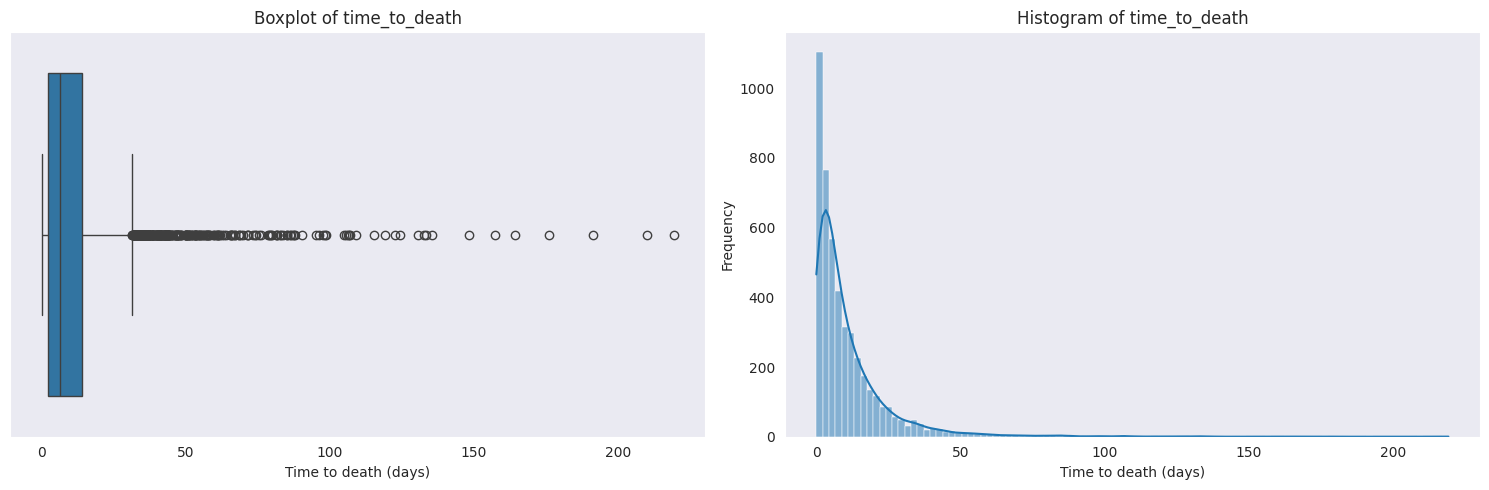

count    4728.000000
mean       11.019815
std        15.301403
min         0.000000
25%         2.325521
50%         6.280903
75%        13.944097
max       219.284028
Name: time_to_death, dtype: float64


In [13]:
# Let's check the target variable
# Plot a subplot of 1 row and 2 columns with historogram and boxplot


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 2)
sns.histplot(df[target], kde=True, bins = 100)
plt.title("Histogram of time_to_death")
plt.xlabel("Time to death (days)")
plt.ylabel("Frequency")


plt.subplot(1, 2, 1)
sns.boxplot(x=df[target])
plt.title("Boxplot of time_to_death")
plt.xlabel("Time to death (days)")
plt.tight_layout()
plt.show()

print(df[target].describe())

### Insight:
1. As seen in the task before the time_to_death is right skewed
2. Most deaths have occured on the same day as they were brought in (0 days)

## 3.2.a) Categorical Features:
Since we have a lot of numerical features let's first check the categorical features and visual them.

In [63]:
# Check for missing values in categorical columns
df[categorical_cols].isnull().mean().sort_values(ascending=False)

gender                                    0.0
race                                      0.0
insurance                                 0.0
admission_type                            0.0
admission_location                        0.0
discharge_location                        0.0
flag_history_CHF_ICD_CODES                0.0
flag_history_DIABETES_ICD_CODES           0.0
flag_history_CKD_ICD_CODES                0.0
flag_history_CANCER_ICD_CODES             0.0
flag_history_COPD_ICD_CODES               0.0
flag_history_LIVER_DISEASE_ICD_CODES      0.0
flag_history_MI_ICD_CODES                 0.0
flag_history_STROKE_ICD_CODES             0.0
flag_history_SEPSIS_ICD_CODES             0.0
flag_history_AKI_ICD_CODES                0.0
flag_chronic_anemia_prior                 0.0
flag_history_on_insulin                   0.0
flag_history_on_diuretics                 0.0
flag_history_on_anticoagulants            0.0
flag_history_on_steroids                  0.0
flag_history_on_chemotherapy      

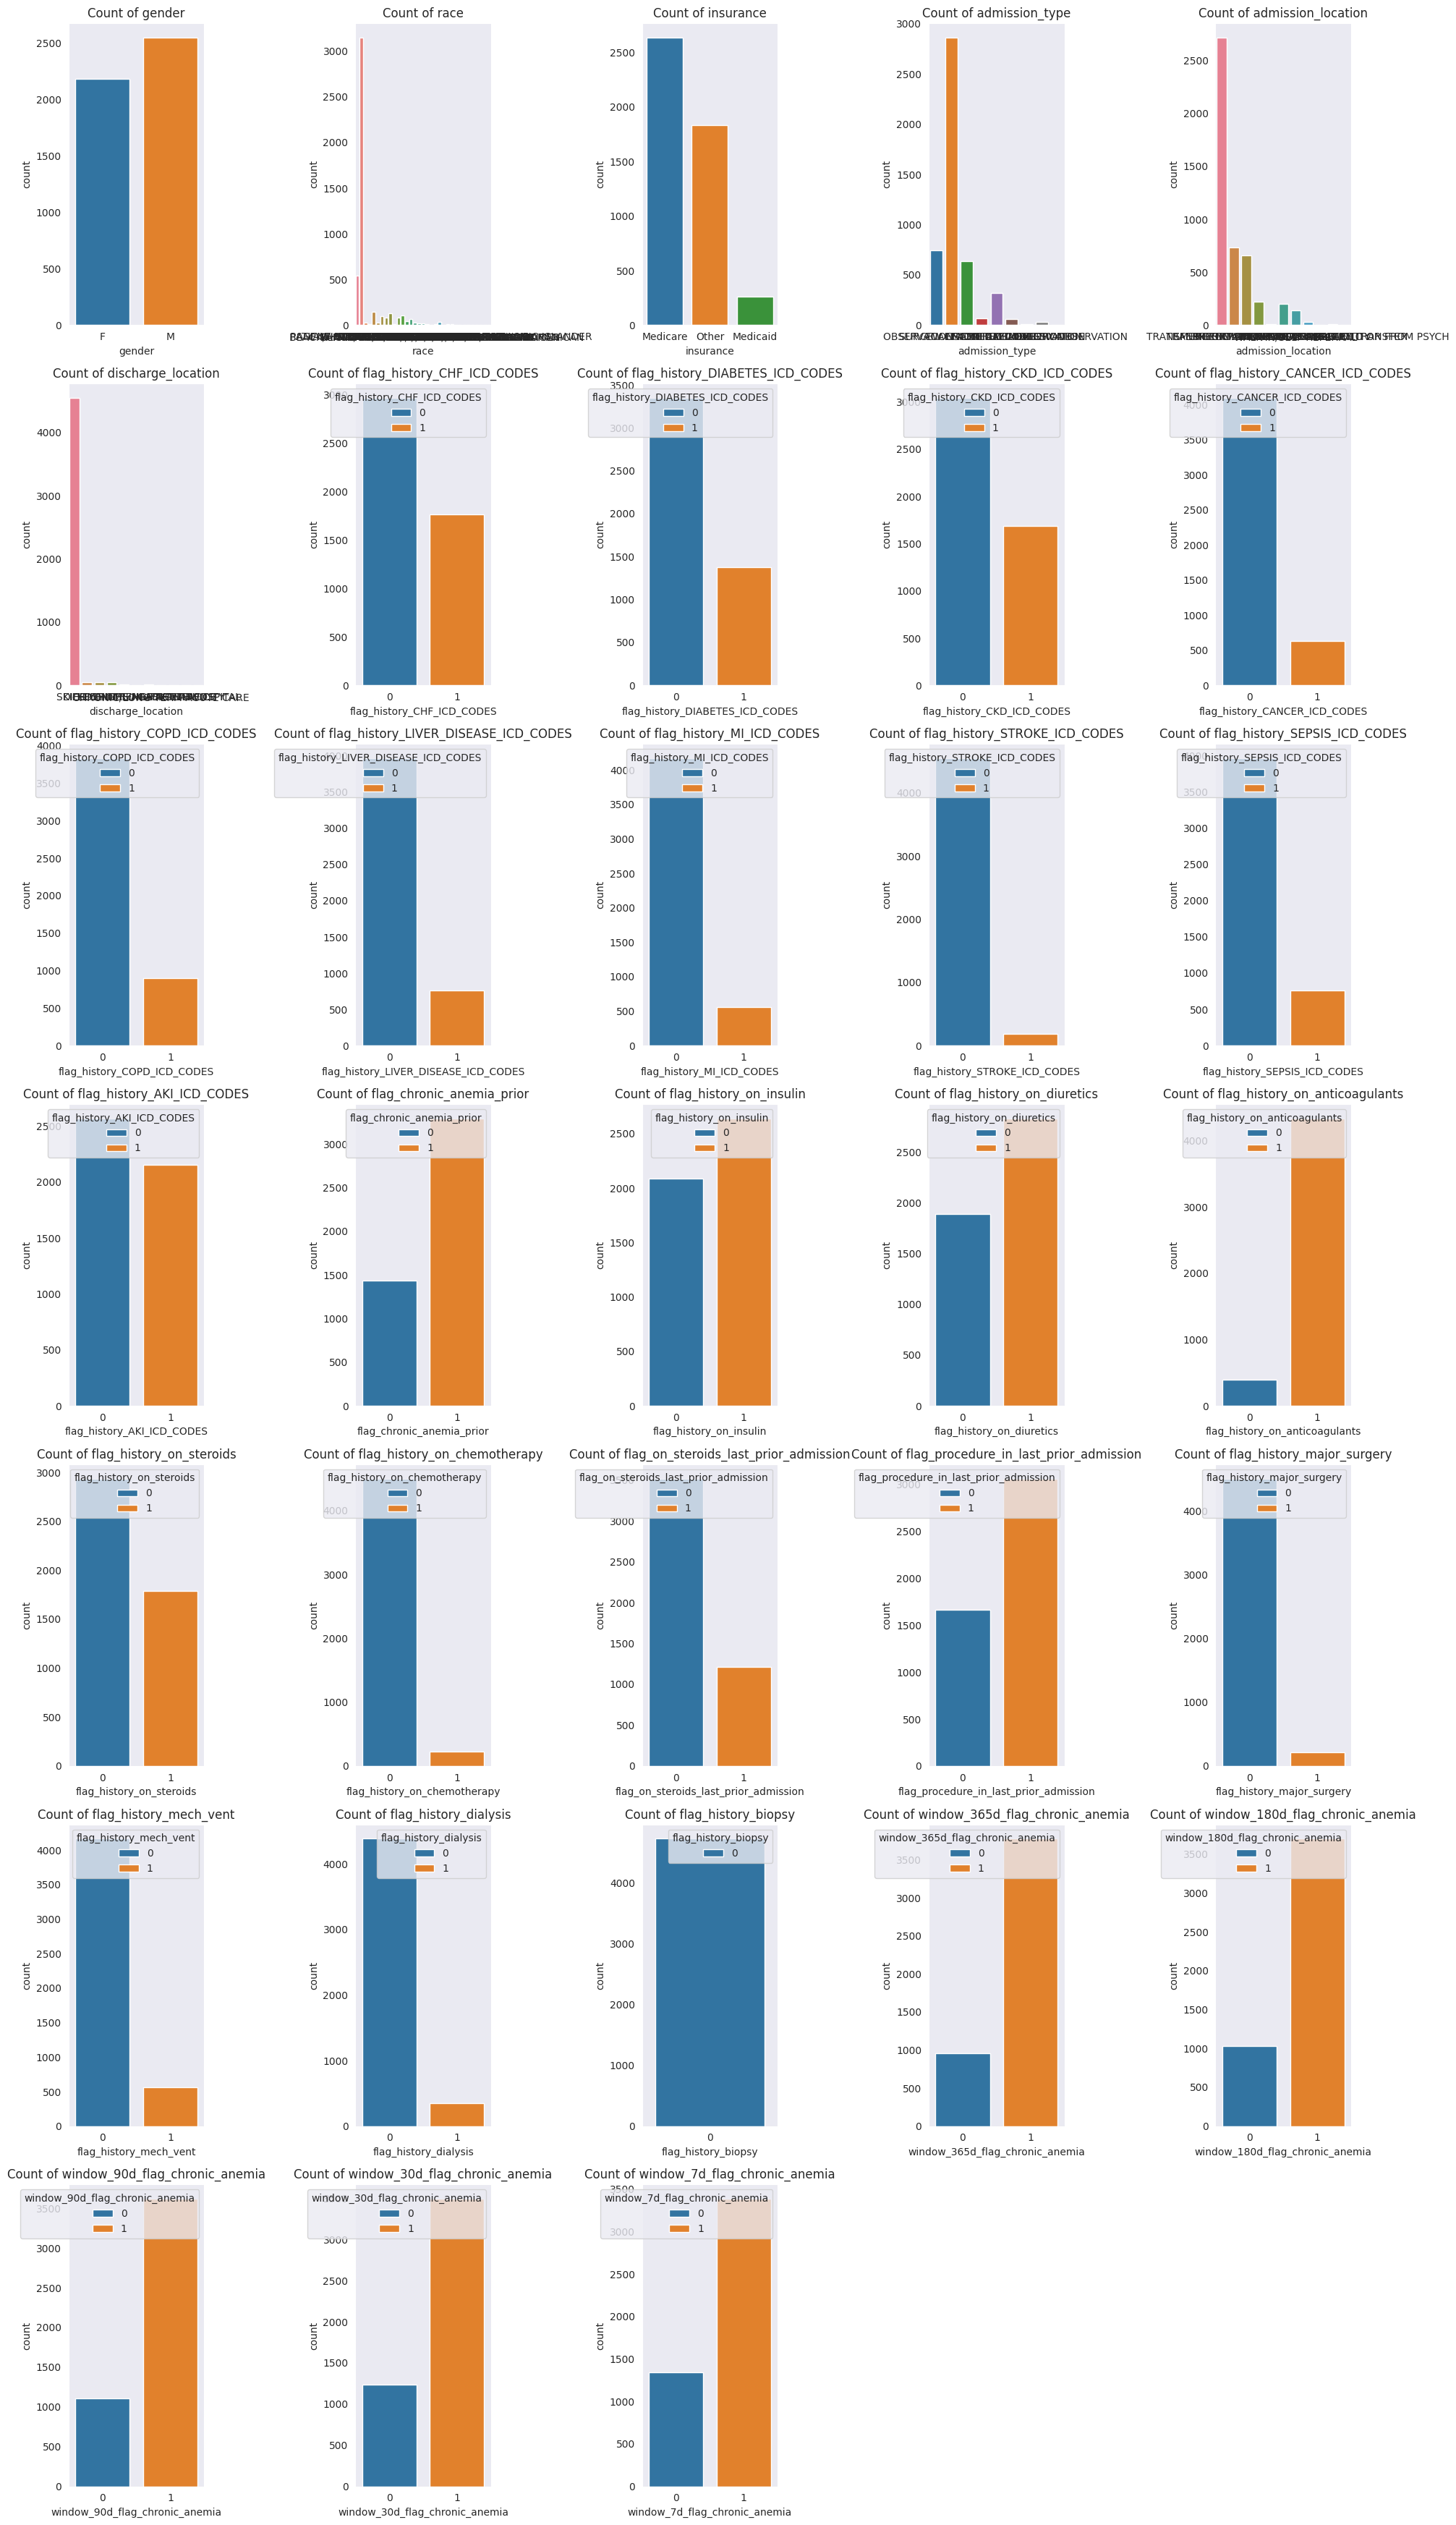

In [64]:
# Let's plot the categorical columns and view their value counts

# Plot categorical columns into subplots of 4 columns each
def plot_categorical_columns(df, categorical_cols):
    num_cols = 5
    num_rows = int(np.ceil(len(categorical_cols) / num_cols))
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(categorical_cols):
        sns.countplot(data=df, x=col, hue=col, ax=axes[i])
        axes[i].set_title(f"Count of {col}")
        # axes[i].tick_params(axis='x', rotation=90)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

plot_categorical_columns(df, categorical_cols) 

### Insights:
1. The race is essentially ethnic background, and the majority of patients are white.
2. We will need to summarize the ethinic background into a few categories. like `White`, `Black`, `Asian`, `Hispanic`, `Other`. `Unknown` (which is 2%) and `Other` (which is 3%) can be combined into `Other`. We will preprocess this later.
3. Insurance is also a categorical variable, and we can see that the majority of patients are covered by Medicare. (55%)
4. Gender is fairly balanced, with a slight majority to the male side (54%).
5. `flag_history_biopsy` has zero variance. We can remove it.
6. The count for `flag_chronic_anemia` doesn't vary much in the different time window.
7. We can simply remove `discharge location` is it popultaed with "DIED"



**`TODO:`**
1. Write categorize_ethnicity to summarize the ethinicity
2. Encode the categories 
3. Remove `flag_history_biopsy`
4. Investigate `flag_chronic_anemia`

## 3.2.b) Numerical Features

We have a lot of them, lets categorize them from the origin:
- Diagnosis
- Labevents
- Prescription
- Procedure

In this example, we will demonstate visualization on Diagnosis variables

In [93]:
df[numerical_cols].isnull().mean().sort_values(ascending=False)[:50]

time_since_first_diagnosis_STROKE_ICD_CODES_years           0.961717
time_since_last_major_surgery_years                         0.953680
time_since_first_diagnosis_MI_ICD_CODES_years               0.882614
time_since_first_diagnosis_CANCER_ICD_CODES_years           0.865905
time_since_first_diagnosis_LIVER_DISEASE_ICD_CODES_years    0.839467
time_since_first_diagnosis_SEPSIS_ICD_CODES_years           0.838621
time_since_first_diagnosis_COPD_ICD_CODES_years             0.810702
time_since_first_diagnosis_DIABETES_ICD_CODES_years         0.708122
time_since_first_diagnosis_CKD_ICD_CODES_years              0.643613
time_since_first_diagnosis_CHF_ICD_CODES_years              0.626692
time_since_first_diagnosis_AKI_ICD_CODES_years              0.543782
window_7d_albumin_max                                       0.179146
window_7d_albumin_min                                       0.179146
window_7d_albumin_avg                                       0.179146
window_7d_albumin_std             

In [83]:
# Categorize the numerical columns into their sources to deal with them easily
from assessment.config import DIAGNOSIS_ICD_COLUMNS

print(f"Total columns: {len(DIAGNOSIS_ICD_COLUMNS)},\nDiagnosis ICD columns: {DIAGNOSIS_ICD_COLUMNS[:5]}...")

Total columns: 35,
Diagnosis ICD columns: ['count_prior_admissions', 'count_unique_diagnoses_prior', 'avg_diagnoses_per_prior_admission', 'time_since_last_admission_days', 'admission_frequency_last_year']...


In [56]:
def plot_histograms(df, numerical_cols, columns, nrows=5, ncols=7):

    valid_cols = [col for col in columns if col in numerical_cols]
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
    for i, col in enumerate(valid_cols):
        ax = axes[i // ncols, i % ncols]
        sns.histplot(df[col], bins=30, kde=True, ax=ax)
        ax.set_title(col)
    for ax in axes.flat:
        ax.label_outer()
        ax.set_xlabel(ax.get_xlabel(), fontsize=8)
        ax.set_ylabel(ax.get_ylabel(), fontsize=8)
        ax.set_title(ax.get_title(), fontsize=8)
    plt.tight_layout()
    plt.show()


def plot_boxplots(df, numerical_cols, columns, nrows=5, ncols=7):

    valid_cols = [col for col in columns if col in numerical_cols]
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
    for i, col in enumerate(valid_cols):
        ax = axes[i // ncols, i % ncols]
        sns.boxplot(df[col], ax=ax, )
        ax.set_title(col)
    for ax in axes.flat:
        ax.label_outer()
        ax.set_xlabel(ax.get_xlabel(), fontsize=8)
        ax.set_ylabel(ax.get_ylabel(), fontsize=8)
        ax.set_title(ax.get_title(), fontsize=8)
    plt.tight_layout()
    plt.show()


def plot_scatterplots(df, numerical_cols, columns, nrows=5, ncols=7):

    valid_cols = [col for col in columns if col in numerical_cols]
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
    for i, col in enumerate(valid_cols):
        ax = axes[i // ncols, i % ncols]
        sns.scatterplot(x = df[col], y = df[target], ax=ax, hue = df[target])
        ax.set_title(col)
    # use small font size for the title
    for ax in axes.flat:
        ax.label_outer()
        ax.set_xlabel(ax.get_xlabel(), fontsize=10)
        ax.set_ylabel(ax.get_ylabel(), fontsize=10)
        ax.set_title(ax.get_title(), fontsize=10)
        ax.grid(True)
    plt.tight_layout()
    plt.show()

### 3.2.b.1) Diagonsis Variables - Univariate 

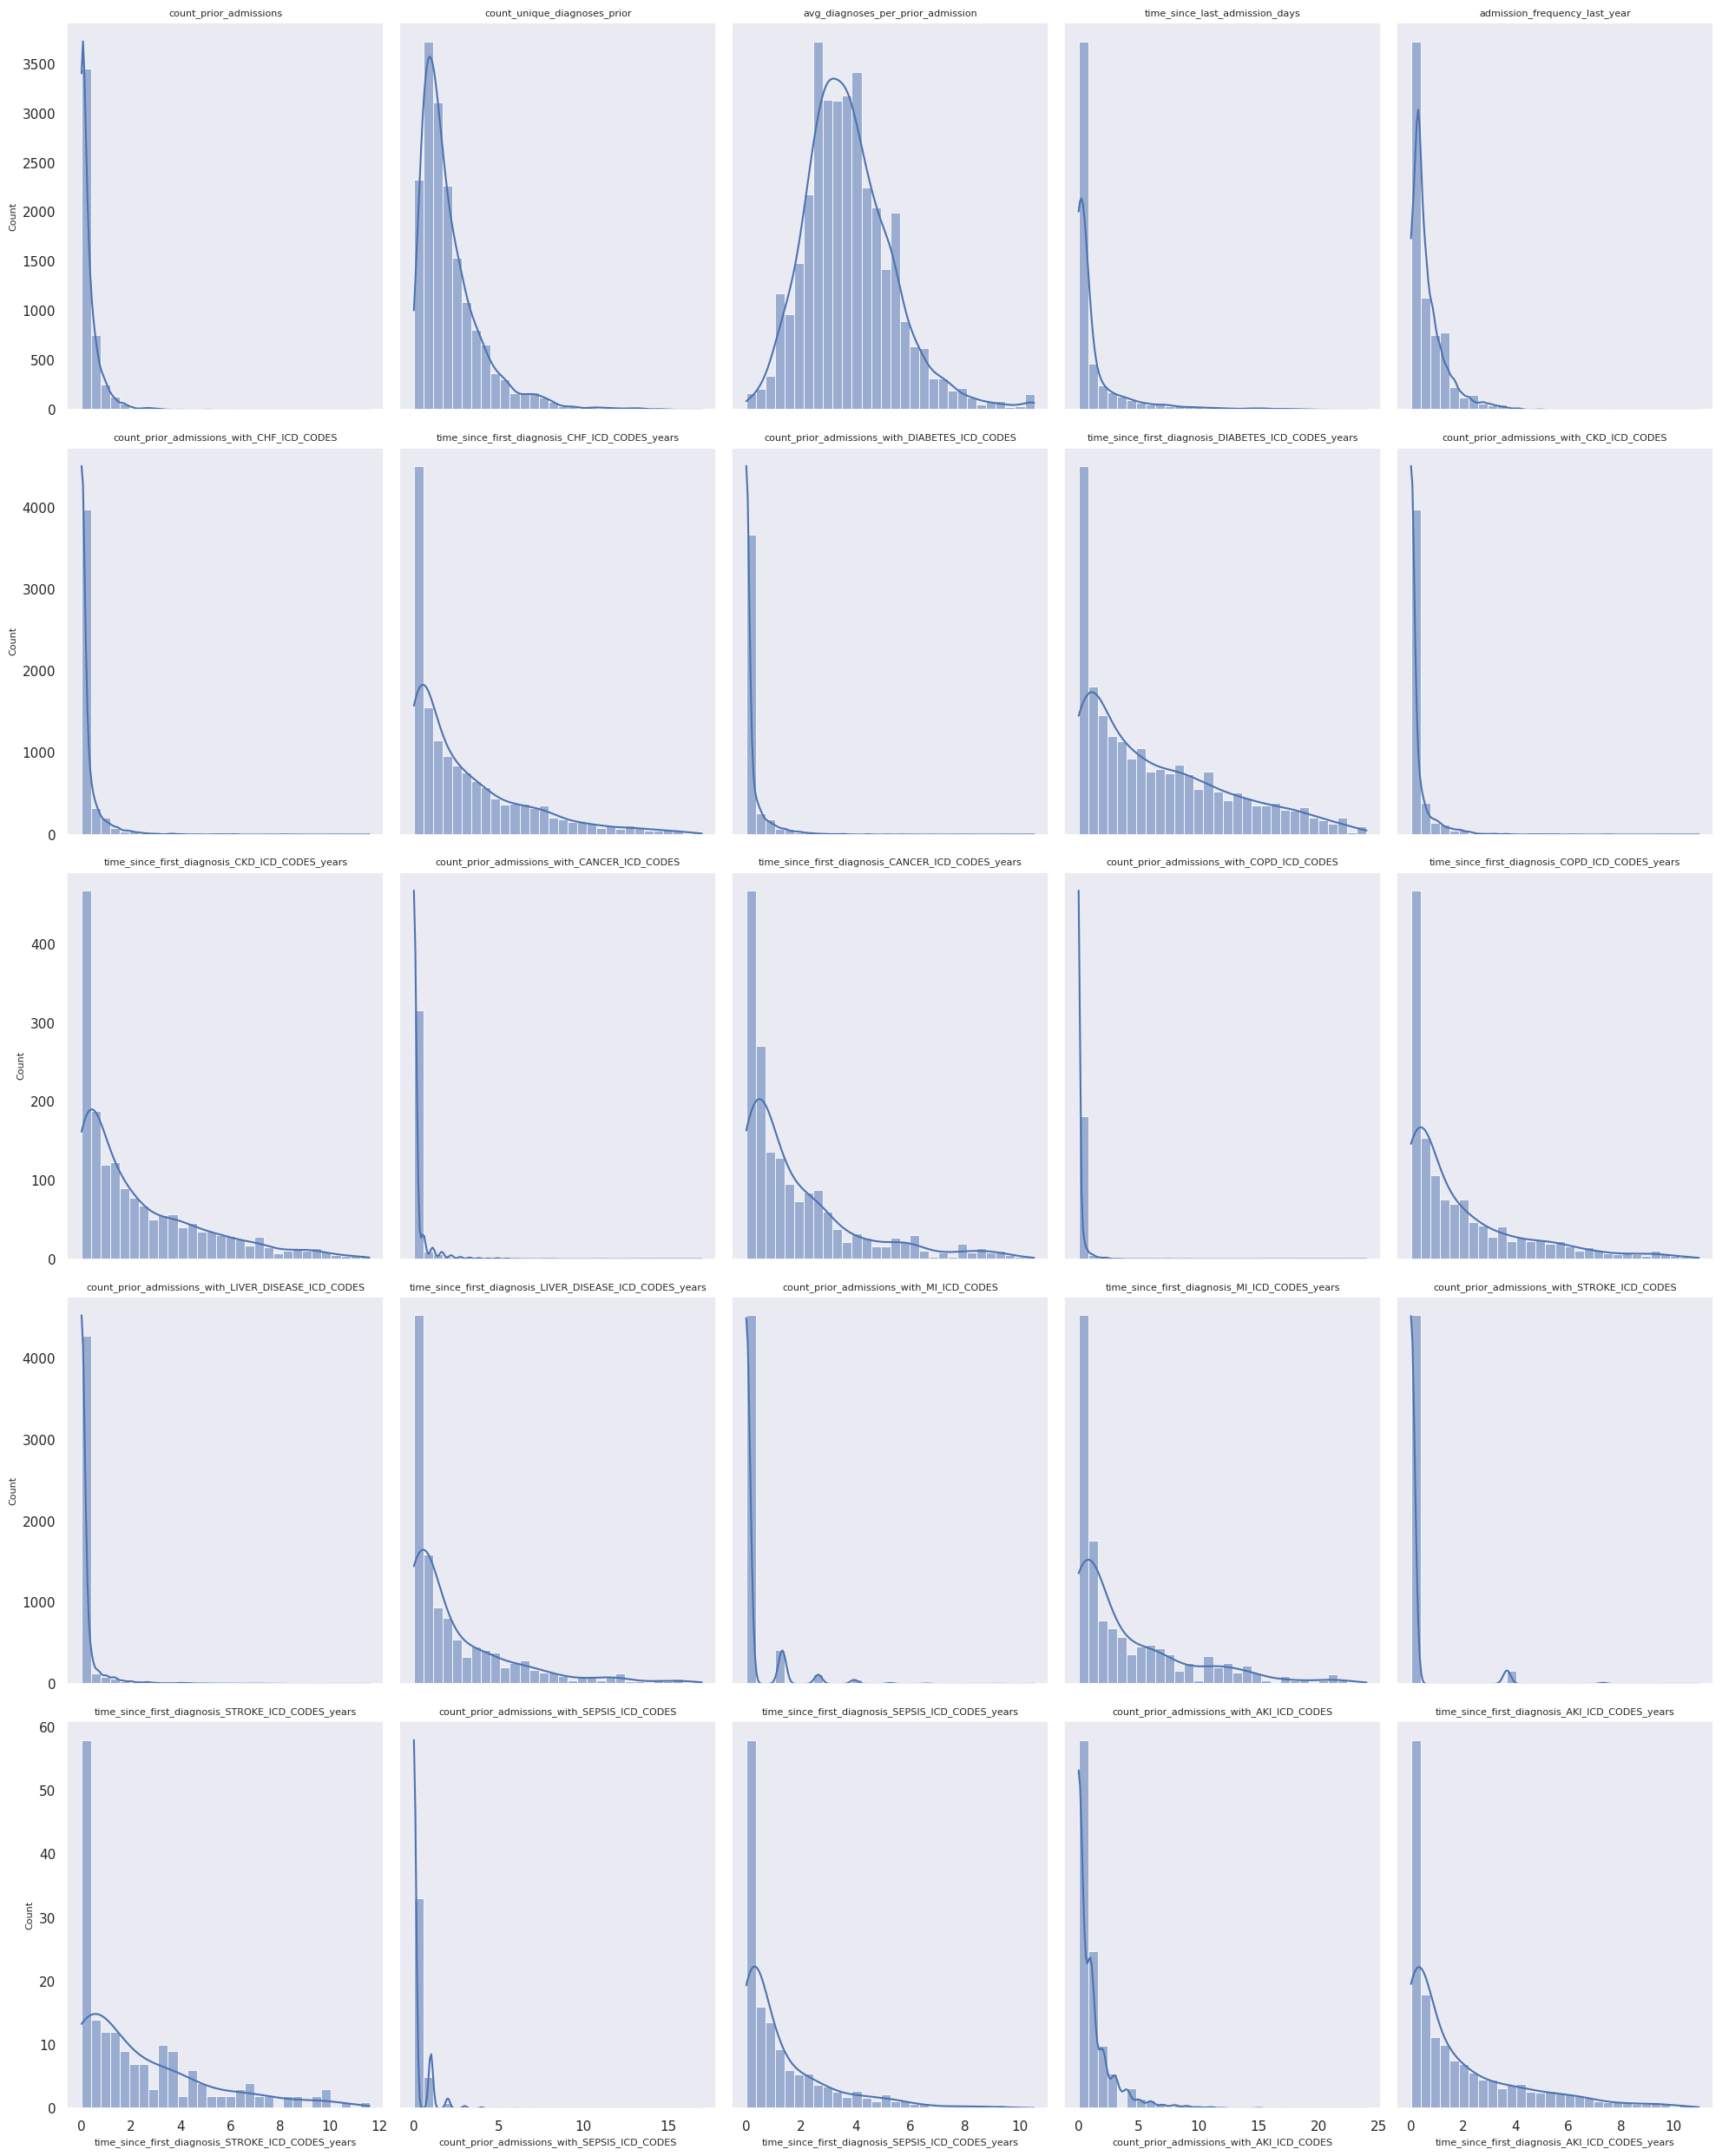

In [21]:
# Visualize histplot using subplots for DIAGNOSIS_ICD_COLUMNS first:
plot_histograms(df, numerical_cols, DIAGNOSIS_ICD_COLUMNS, nrows=5, ncols=5)

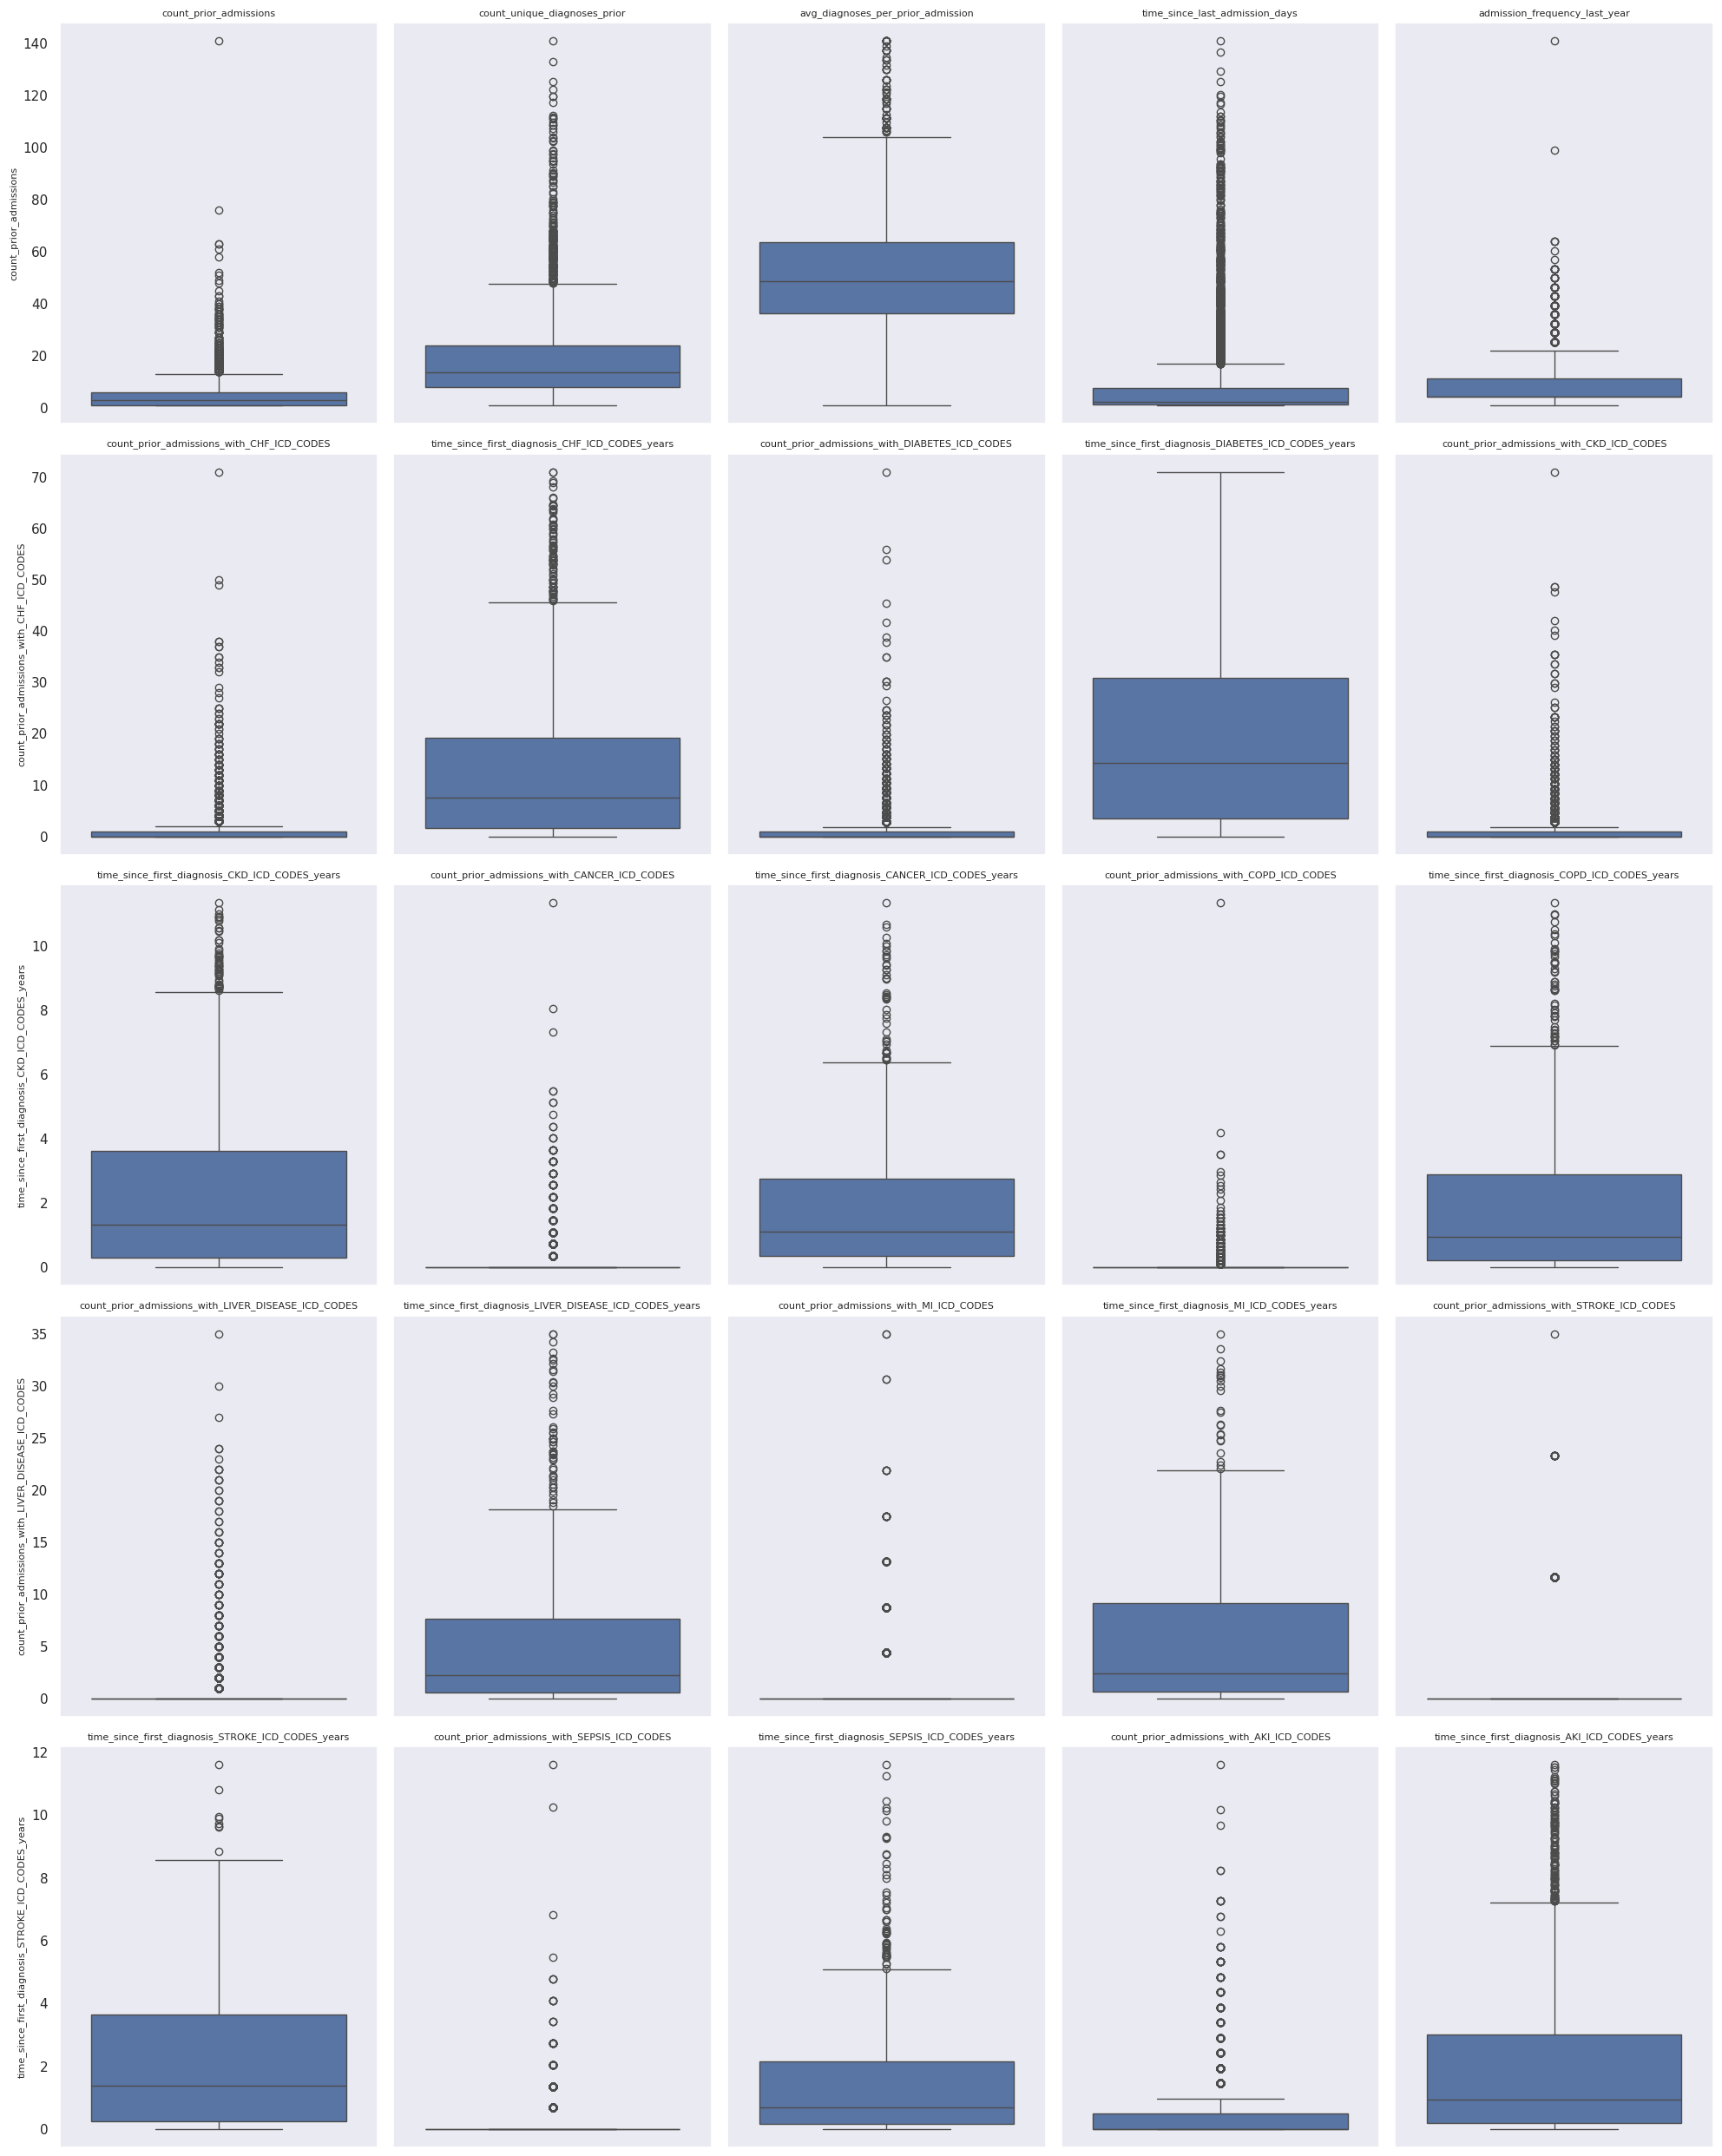

In [22]:
# Visualize boxplots using subplots for DIAGNOSIS_ICD_COLUMNS first:

plot_boxplots(df, numerical_cols, DIAGNOSIS_ICD_COLUMNS, nrows=5, ncols=5)

### Insights:
1. Most of the variables are heavily right-skewed. 
2. WE need to deal with outliers and We might need to apply log transformation or other transformations to normalize the data.
3. The only varible that appears normally distributed is `average_diagnosis_per_prior_admissions`

**`TODO`**
1. Deal with outliers.
2. Apply log transformation to the numerical_cols of diagonisis numerical col


### 3.2.b.2) Diagonsis Variables - Bivariate 

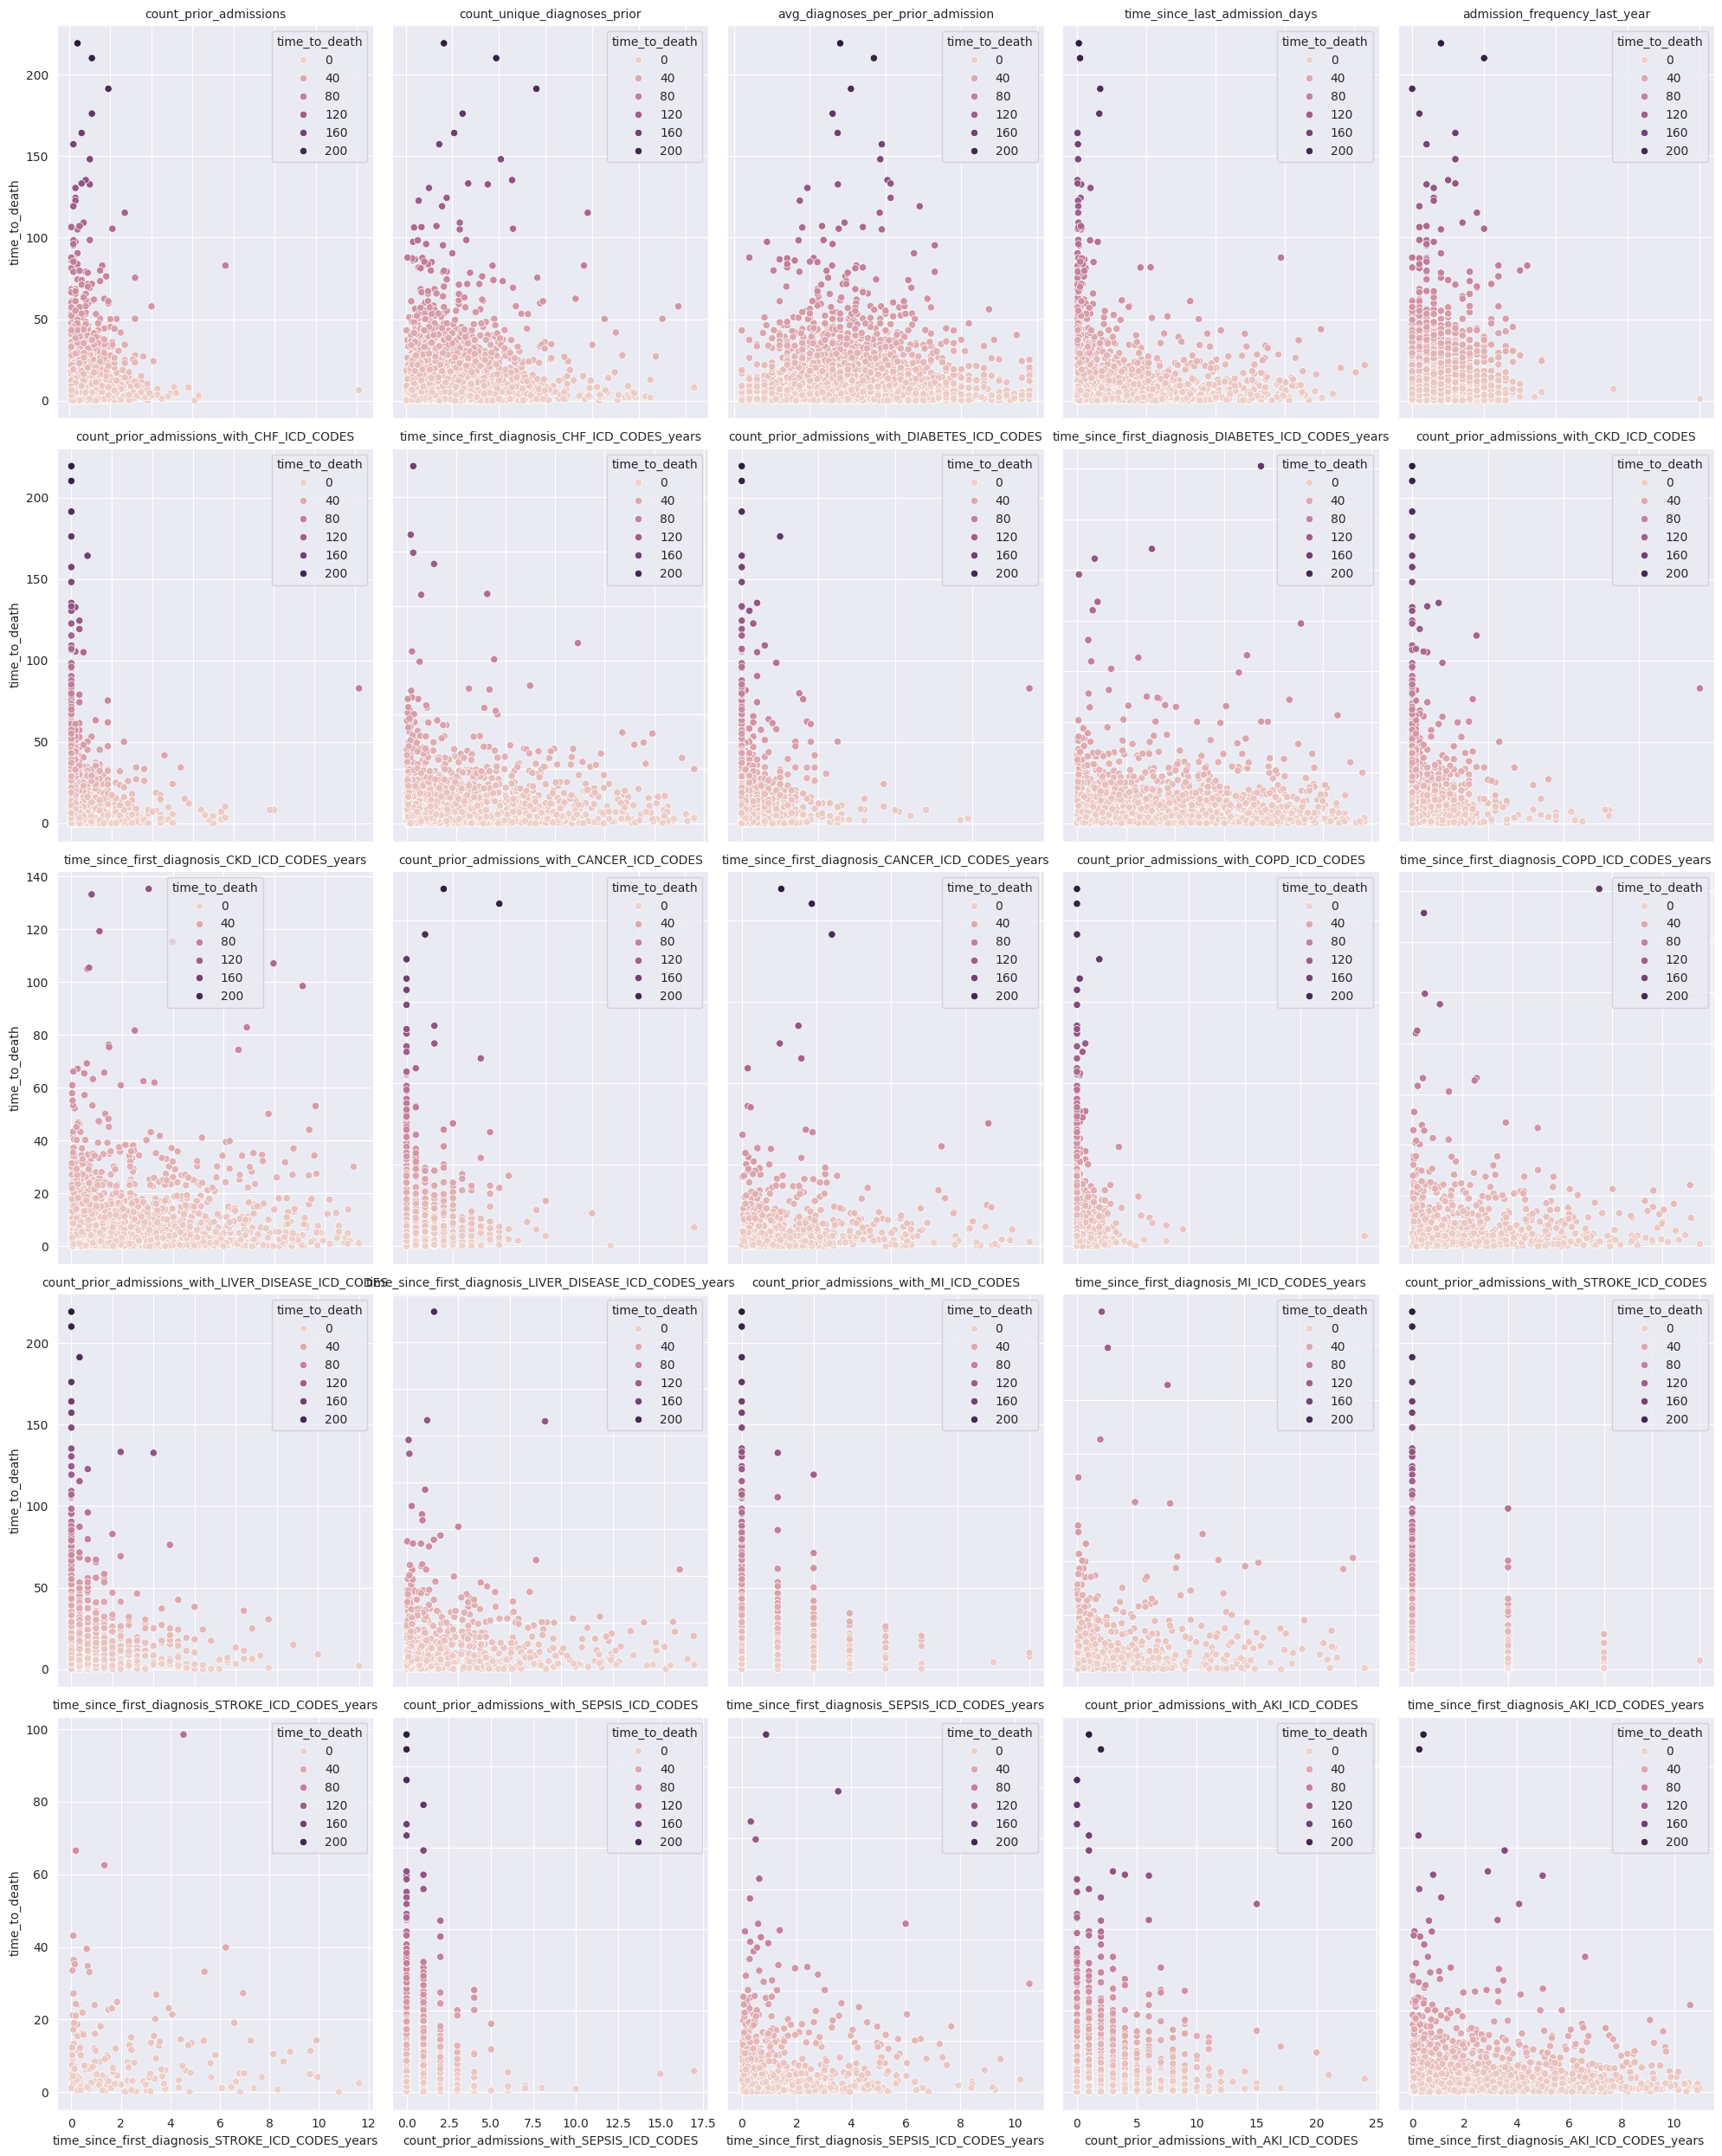

In [57]:
plot_scatterplots(df, numerical_cols, DIAGNOSIS_ICD_COLUMNS, nrows=5, ncols=5)

### 3.2.b.3) Multivariate - Correlation:

<Axes: >

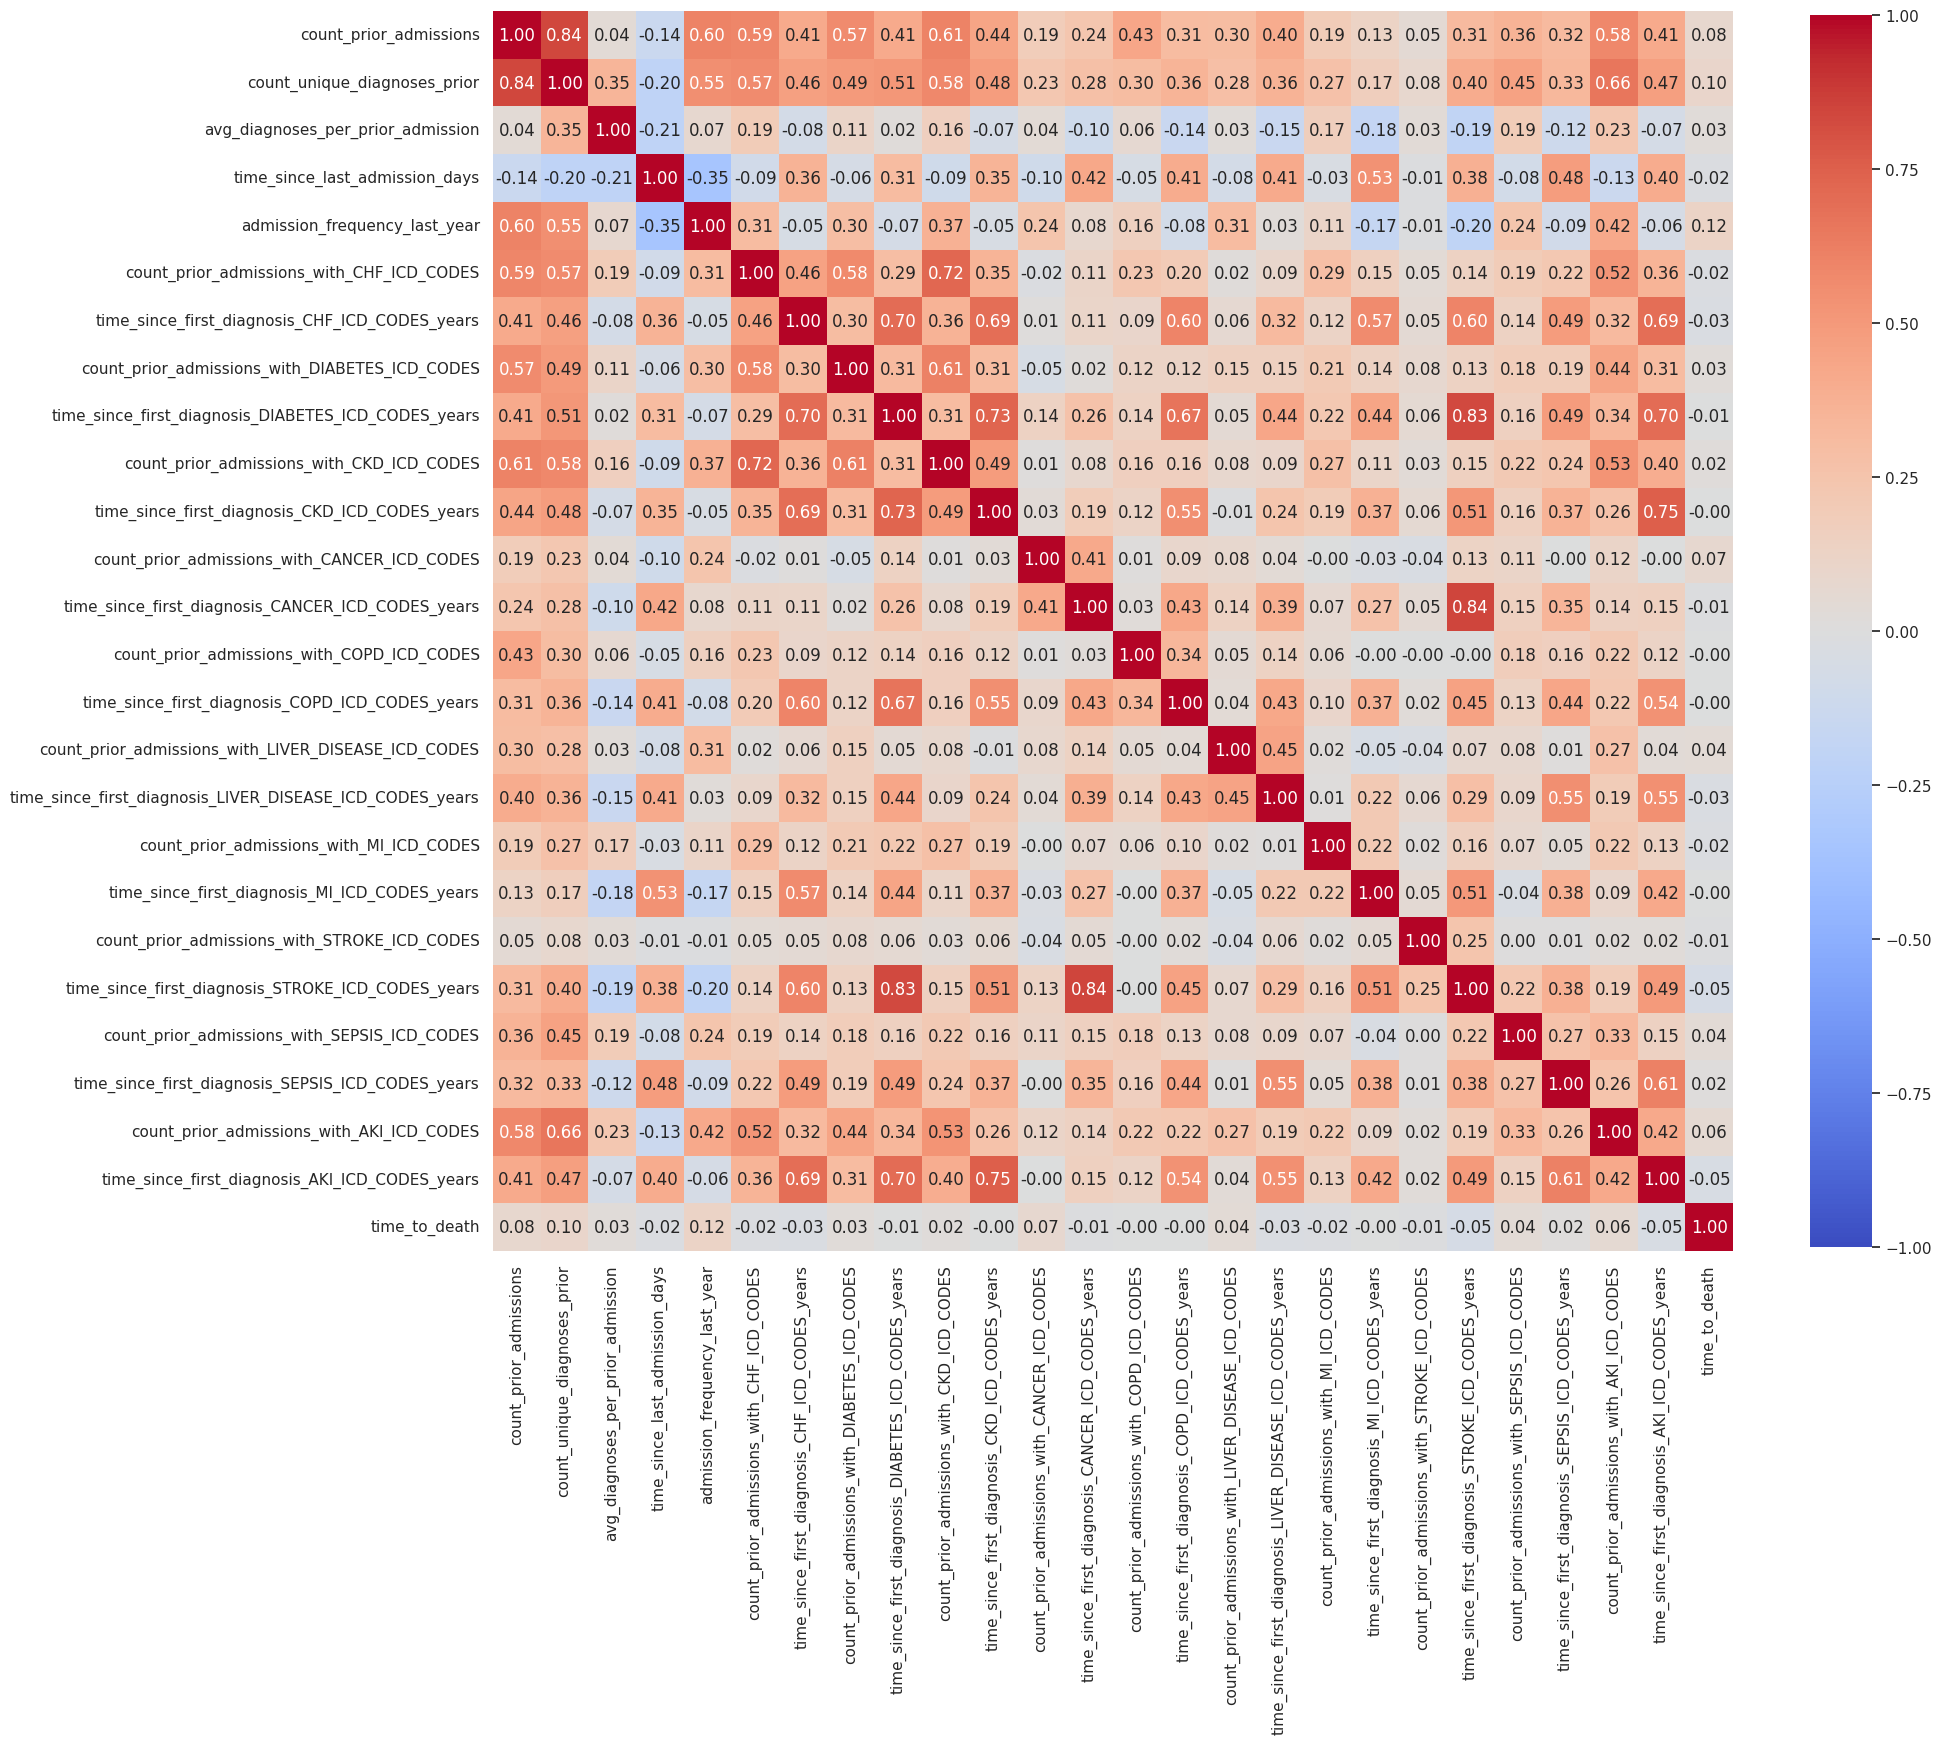

In [24]:
# Plot correlation matrix for DIAGNOSIS_ICD_COLUMNS heatmap
valid_cols = [col for col in DIAGNOSIS_ICD_COLUMNS if col in numerical_cols]
col = valid_cols + [target]

plt.figure(figsize=(20,20))
sns.heatmap(df[col].corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8}, vmax=1, vmin=-1)

### Insight:
1. Many features created have strong positive linear correlations
2. Most features don't have any linear correlationship with the labels


Similar EDA can be replicated for other Labevents, Prescription, Procedure.

## 3.3 Feature Preprocessing

In this section, we focus on processing the features that we have created


Categorical:
- Ethinicity variable - Grouping
- Admission type - Grouping
- One hot encoding

Numerical:
- Imputing
- MinMax Scaling

We'll be creating sklearn pipeline to achieve this!

In [92]:
from sklearn.model_selection import train_test_split

columns_to_remove.append(target)
X = df.drop(columns=columns_to_remove, errors="ignore")
y = df[target]

## 3.3.1 Categorical Features

In [93]:
# Function that changes the values of the column to the values in the mapping
def map_columns(df, old_column, new_column, mapping, is_categorical=True):
    df[new_column] = df[old_column].map(mapping)
    df.drop(columns=[old_column], inplace=True, errors='ignore')
    print(f"Mapping {old_column} to {new_column}")
    return df

In [94]:
# Reference: https://pmc.ncbi.nlm.nih.gov/articles/PMC10524813/#s1:~:text=of%20Stay%20Criteria.-,Asian,Demographics,-Age%2C%20years%2C%20median

from assessment.config import ETHNICITY_MAPPING

old_column = "race"
new_column = "grouped_ethnicity"
display(X[old_column].value_counts(normalize=True))
X = map_columns(X, "race", "grouped_ethnicity", ETHNICITY_MAPPING, is_categorical=True)
display(X[new_column].value_counts(normalize=True))
X["grouped_ethnicity"].value_counts(normalize=True)

categorical_cols.append(new_column)
categorical_cols.remove(old_column)

race
WHITE                                        0.665609
BLACK/AFRICAN AMERICAN                       0.114636
UNKNOWN                                      0.031091
OTHER                                        0.027284
WHITE - OTHER EUROPEAN                       0.022420
WHITE - RUSSIAN                              0.021151
ASIAN - CHINESE                              0.018190
ASIAN                                        0.018190
HISPANIC/LATINO - PUERTO RICAN               0.014171
HISPANIC OR LATINO                           0.008883
BLACK/CARIBBEAN ISLAND                       0.006980
ASIAN - SOUTH EAST ASIAN                     0.006557
HISPANIC/LATINO - DOMINICAN                  0.005922
BLACK/CAPE VERDEAN                           0.005922
PORTUGUESE                                   0.004653
BLACK/AFRICAN                                0.004230
WHITE - EASTERN EUROPEAN                     0.002961
UNABLE TO OBTAIN                             0.002961
ASIAN - ASIAN INDIAN   

Mapping race to grouped_ethnicity


grouped_ethnicity
White                     0.718274
Black/African American    0.131768
Other                     0.066836
Asian                     0.046743
Hispanic/Latino           0.036379
Name: proportion, dtype: float64

In [95]:
# Map: What are the meanings of different "admission type" values in MIMIC IV?  # 1215 https://github.com/MIT-LCP/mimic-code/discussions/1215


from assessment.config import ADMISSION_TYPE_MAPPING

old_column = "admission_type"
new_column = "grouped_admission_type"
display(X["admission_type"].value_counts(normalize=True))
X = map_columns(X, "admission_type", "grouped_admission_type", ADMISSION_TYPE_MAPPING, is_categorical=True)
display(X["grouped_admission_type"].value_counts(normalize=True))

categorical_cols.append(new_column)
categorical_cols.remove(old_column)

admission_type
EW EMER.                       0.604907
OBSERVATION ADMIT              0.157149
URGENT                         0.134306
DIRECT EMER.                   0.068316
SURGICAL SAME DAY ADMISSION    0.014382
ELECTIVE                       0.012479
EU OBSERVATION                 0.006768
DIRECT OBSERVATION             0.001481
AMBULATORY OBSERVATION         0.000212
Name: proportion, dtype: float64

Mapping admission_type to grouped_admission_type


grouped_admission_type
EMERGENCY    0.932013
ELECTIVE     0.067987
Name: proportion, dtype: float64

## 3.2.d) Population features with time to death:

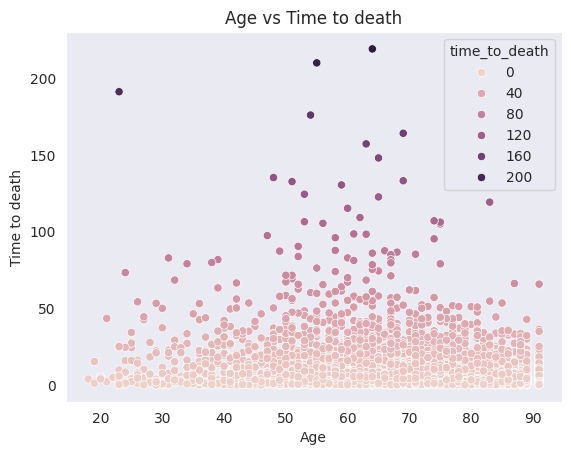

In [96]:
# Age
pop_num_cols = ["age"]

sns.scatterplot(x = X["age"], y = y, hue = y)
plt.title("Age vs Time to death")
plt.xlabel("Age")
plt.ylabel("Time to death")
plt.show()

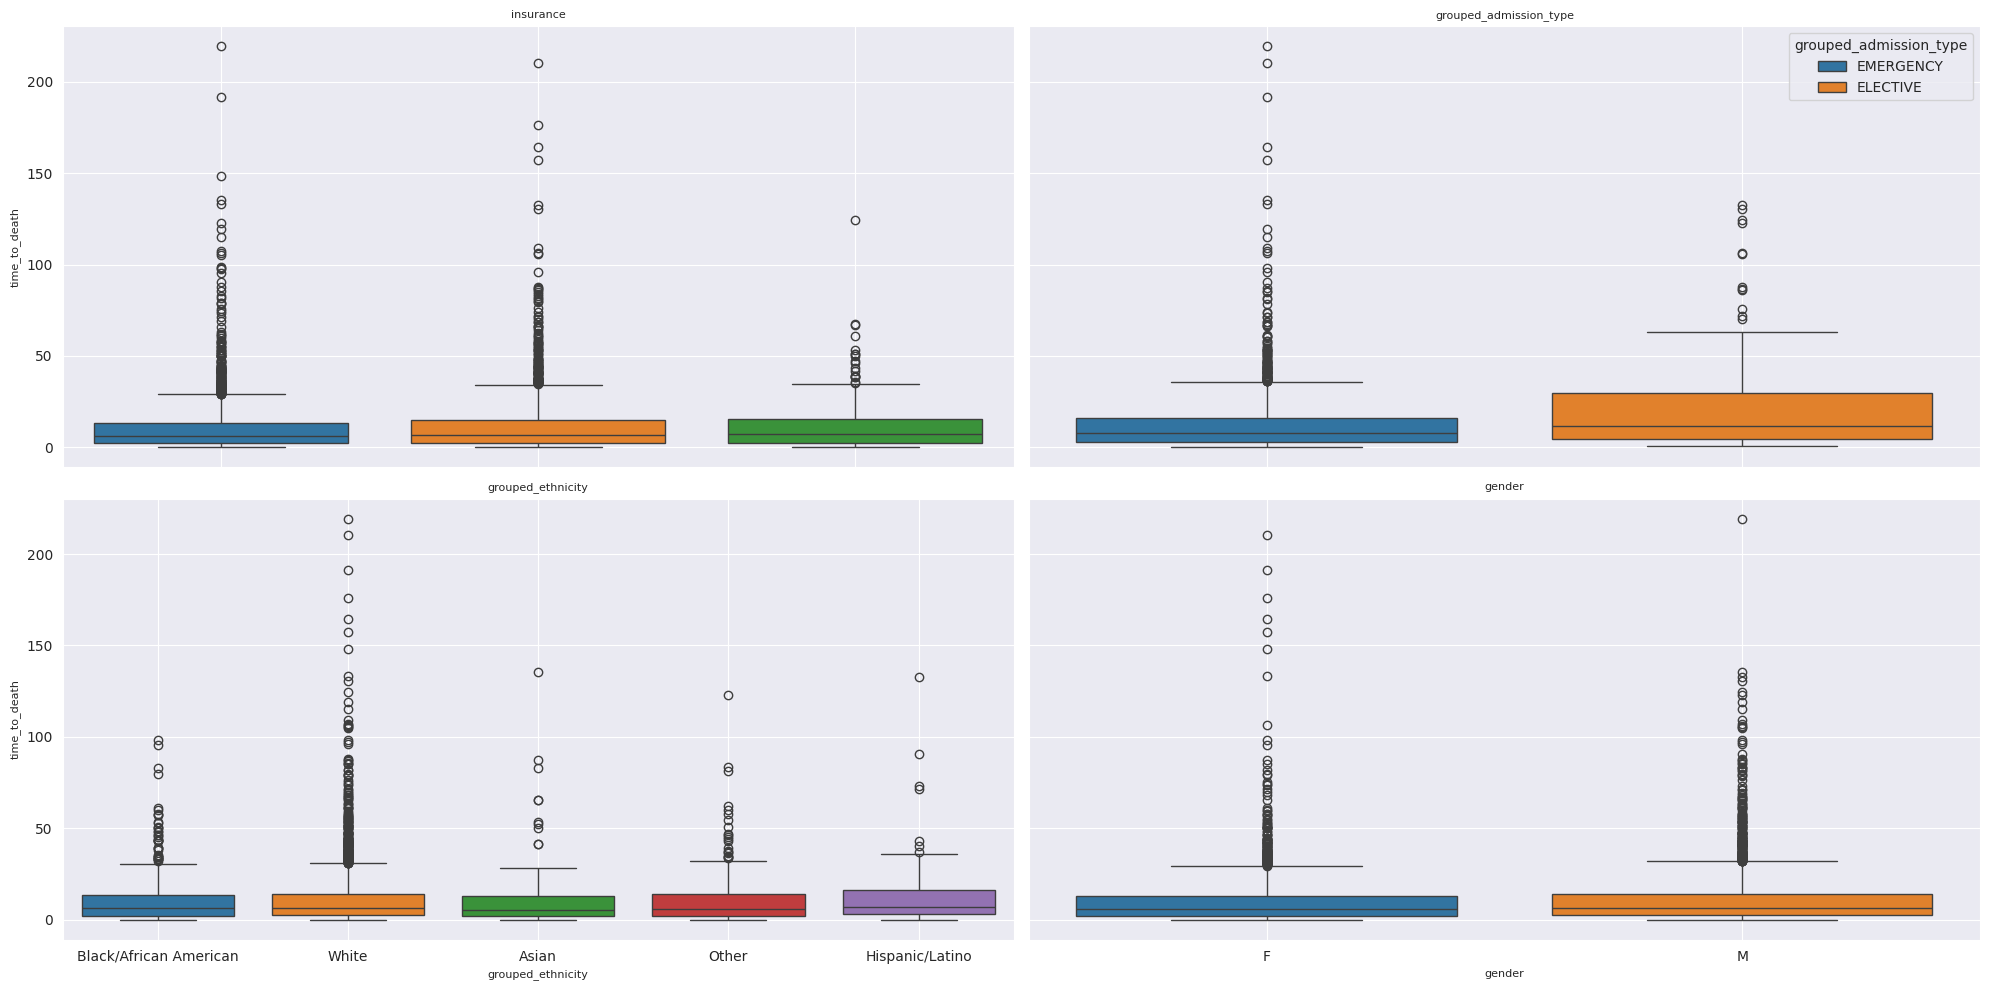

In [89]:
pop_cat_cols = ["insurance", "grouped_admission_type", "grouped_ethnicity", "gender"]
# Plot boxplot columns with time to death
def plot_boxplot(df, cat_cols, target):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
    for i, col in enumerate(cat_cols):
        ax = axes[i // 2, i % 2]
        sns.boxplot(x=X[col], y=y, ax=ax, hue = X[col])
        ax.set_title(col)
    for ax in axes.flat:
        ax.label_outer()
        ax.set_xlabel(ax.get_xlabel(), fontsize=8)
        ax.set_ylabel(ax.get_ylabel(), fontsize=8)
        ax.set_title(ax.get_title(), fontsize=8)
        ax.grid(True)
    plt.tight_layout()
    plt.show()
plot_boxplot(X, pop_cat_cols, target)

### Insight:
1. Insurance: Patients with elective admissions tend to have higher variability and median time_to_death compared to emergency admissions.
2. Grouped Admission Type: Elective admissions show a higher median and wider spread in time_to_death compared to emergency admissions.
3. Grouped Ethnicity: White patients have a slightly higher median and variability in time_to_death compared to other ethnic groups.
4. Gender: Males show a slightly higher median and variability in time_to_death compared to females.

## 3.3.2 Numerical Features

Split train and test.
Fit on train, transform on test.

**Imputing Missing Values with Flags**:
For features like `"time_since_first_diagnosis_CANCER_ICD_CODES"`, `"time_since_first_diagnosis_STROKE_ICD_CODES`...." 

I will be using zero imputation alongside a count variable `count_prior_admissions_with_CANCER_ICD_CODES`, `count_prior_admissions_with_STROKE_ICD_CODES` to indicating whether the value was missing. I assumed that missingness might reflect clinical absence (e.g., never diagnosed) rather than random noise.

Other options was using a very high value. 

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
print(f"Shape of train:{X_train.shape}, Shape of test: {X_test.shape}")

Shape of train:(4018, 387), Shape of test: (710, 387)


In [116]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def winsorization(X, perc = 2):
    lower, upper = np.percentile(X, perc) , np.percentile(X, 100 - perc)
    return np.clip(X, lower, upper)  



numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # ('winsorization', FunctionTransformer(winsorization)),
    ('scaler', MinMaxScaler()),

])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output= False, drop = "first", handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        # ("time_zero_imputation", FunctionTransformer(lambda x: x.fillna(0)), time_since_col),
        # ('num', numerical_transformer, list(set(numerical_cols) - set(time_since_col))),
        ('num', numerical_transformer, numerical_cols),
        ('nom', nominal_transformer, categorical_cols),
    ],
    remainder='passthrough'
).set_output(transform="pandas")

In [117]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_train_processed.shape, X_test_processed.shape

((4018, 390), (710, 390))

In [ ]:
# Save the data for the next step
# from assessment.config import PROCESSED_DATA_DIR

# X_train_processed.to_csv(PROCESSED_DATA_DIR / "X_train_processed.csv", index=False)
# X_test_processed.to_csv(PROCESSED_DATA_DIR / "X_test_processed.csv", index=False)
# y_train.to_csv(PROCESSED_DATA_DIR / "y_train.csv", index=False)
# y_test.to_csv(PROCESSED_DATA_DIR / "y_test.csv", index=False)

In [101]:
# Create new columns after transformation

numerical_cols_2 = [col for col in X_train_processed.columns if col.startswith("num")]
categorical_cols_2 = [col for col in X_train_processed.columns if col.startswith("nom")]

print(f"Numerical columns: {len(numerical_cols_2)}")
print(f"Categorical columns: {len(categorical_cols_2)}")

Numerical columns: 344
Categorical columns: 34


In [102]:
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA



num_transf = ColumnTransformer([
    ("square", FunctionTransformer(func = np.square), numerical_cols_2),
    ("log_trans", FunctionTransformer(func = np.log1p), numerical_cols_2),
    ("pca", PCA(n_components=2), numerical_cols_2)
], remainder="passthrough").set_output(transform="pandas")


# Subtask 4: Modelling Approaches
Implement different models. Explain and justify your modelling approach.


Approach:
1. Integrating sklearn pipelines including:
    1. Numerical transformer (num_transf) which is generating transformed features, 
    2. Feature selection using a `DecisionTreeRegressor` as the estimator.
    3. Final regression model, including:
        1. Baseline (`DummyRegressor`)
        2. Linear with robustness for outlier (`LinearRegression` & `HuberRegressor`), 
        3. Ensemble-based (`RandomForestRegressor`, `XGBRegressor`, `HistGradientBoostingRegressor`)
2. Cross-validation with 10 folds, with scoring on mean squared error (MSE)
3. Metrics: MSE and R²

Future work includes hyperparameter optimization using grid searches or Optuna, which is currently out of scope.

## 4. Modelling

In [103]:
# Modeling pipeline

from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

import joblib

from assessment.config import MODELS_DIR

In [ ]:
models = {
    "dummy" : DummyRegressor(),
    "lr" : LinearRegression(),
    "hub" : HuberRegressor(max_iter=3000,),
    "rf" : RandomForestRegressor(max_depth=5),
    "xgboost" : XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.1),
    "hist" : HistGradientBoostingRegressor(max_depth=5, learning_rate=0.1),
}

fitted_pipelines = {}

estimator = DecisionTreeRegressor(random_state=42, max_depth=5)

for name, model in models.items():
    print("="*20, name, "="*20)

    full_pipeline = Pipeline([
        ("trans", num_transf),
        ("selection", SelectFromModel(estimator, max_features=int(np.sqrt(X_train_processed.shape[0])))),
        ("model", model)
    ]).set_output(transform="pandas")


    cv_scores = cross_val_score(full_pipeline, X_train_processed, y_train, cv = 10, scoring="neg_mean_squared_error")
    print(cv_scores, np.mean(cv_scores), np.std(cv_scores))


    # Fully train the pipeline


    full_pipeline.fit(X_train_processed,y_train)
    y_pred = full_pipeline.predict(X_test_processed)

    mse = mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test, y_pred)

    print("MSE: ", mse)
    print("R2:", r2)

    # Save pipeline
    fitted_pipelines[name] = full_pipeline
    pipeline_name = MODELS_DIR / f"{name}_pipeline.pkl"
    # joblib.dump(full_pipeline, pipeline_name)

==================== dummy ====================
[-201.87602315 -294.05624622 -296.04294998 -202.88880006 -217.57741385
 -296.82824906 -226.6576853  -215.54506735 -147.8162254  -273.3908028 ] -237.26794631822457 47.89572523965506
MSE:  216.13487327787507
R2: -0.00019273320710211372
==================== lr ====================
[-48.46291424 -32.32685611 -44.33698073 -39.67524218 -62.84236361
 -65.41995164 -52.04317919 -37.46891748 -34.71296764 -37.6831473 ] -45.49725201105546 10.954121167133541
MSE:  44.15551194592653
R2: 0.795664524148422
==================== hub ====================
[-49.54681786 -34.17177326 -47.2417681  -41.54840777 -62.08922943
 -69.81278479 -53.26307479 -39.13963484 -34.60389537 -38.20218166] -46.96195678758404 11.318118120757074
MSE:  46.32029466042896
R2: 0.7856467056114108
==================== rf ====================
[-57.60039566 -27.39581371 -57.64133675 -33.23404309 -53.20855819
 -46.99403017 -45.05895105 -35.57571703 -27.42131013 -45.58794232] -42.9718098096

## Insights: Best model is `XGBoost` with a MSE = 29.43, R2 = 0.863. 

Model Details:

1. `Dummy Regressor`: Performs poorly with R² close to 0, indicating it fails to capture any meaningful patterns in the data.
2. `Linear Regression (LR)`: Achieves improvement with an MSE of 44.16 and an R² of 0.796, showing it captures the data's linear relationships effectively.
3. `Huber Regressor (Hub)`: Performs similarly to LR with an MSE of 46.32 and an R² of 0.786, indicating robustness to outliers but slightly lower performance.
4. `Random Forest` (RF): Outperforms LR and Hub with an MSE of 34.49 and an R² of 0.840,`suggesting it captures non-linear relationships well.
5. `XGBoost`: Delivers the best performance with the lowest MSE of 29.43 and the highest R² of 0.864, indicating strong predictive power and effective handling of complex patterns.
6. `Histogram-based Gradient Boosting` (Hist): Performs comparably to RF with an MSE of 34.96 and an R² of 0.838, showing it is also effective but slightly less optimal than XGBoost.

In [ ]:
# Save fitted_pipelines
# for name, pipeline in fitted_pipelines.items():
#     joblib.dump(pipeline, MODELS_DIR / f"{name}_pipeline.pkl")

In [107]:
# Load from saved fitted_pipelines

fitted_pipelines = {}
for name in models.keys():
    if name == "dummy":
        continue
    pipeline_name = MODELS_DIR / f"{name}_pipeline.pkl"
    fitted_pipelines[name] = joblib.load(pipeline_name)

# Task 3: Performance & Explainability Analysis 

1. Evaluate your models using appropriate metrics (AUC, precision, recall, F1, or concordance index). 
2. Provide confusion matrices and stratified performance analysis (e.g., by age, 
gender). 
3. Apply model interpretability methods such as SHAP to explain predictions. 
4. Bonus: Compare your results across hospital and ICU cohorts or investigate the 
different causes of death. 


# Subtask 1: Evaluate your models using appropriate metrics
We choose MSE and R2 as our primary metrics for regression task


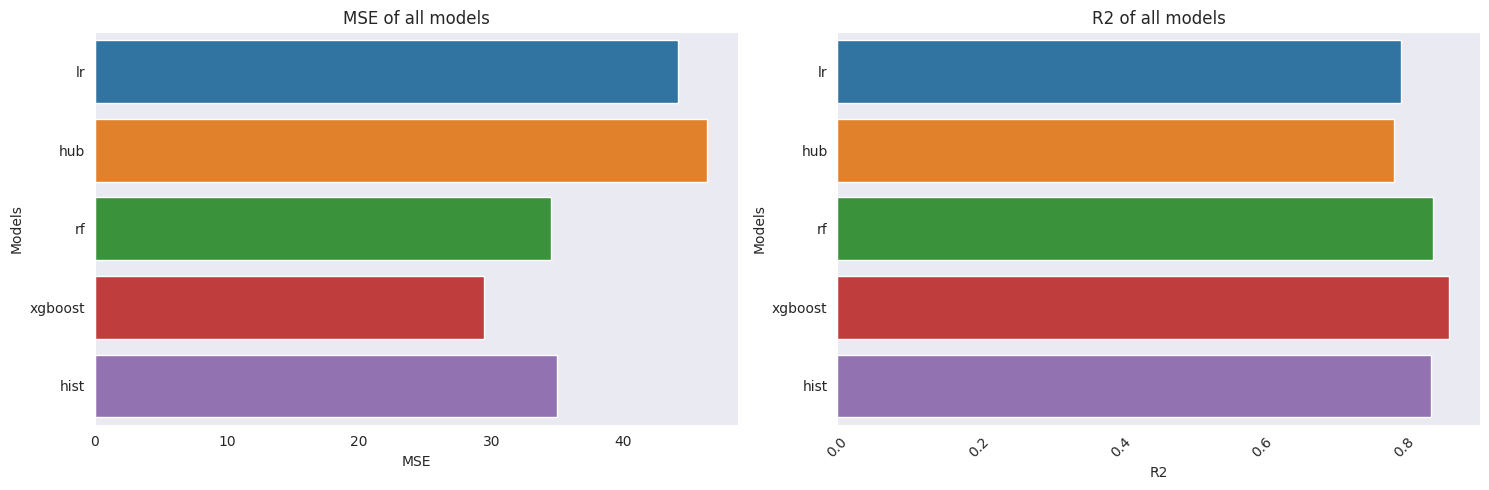

In [ ]:
# Using full pipeline, plot MSE and R2 for all models
def plot_model_performance(fitted_pipelines, X_train, y_train, X_test, y_test):
    mse_list = []
    r2_list = []
    names = []
    for name, pipeline in fitted_pipelines.items():
        if name == "dummy":
            continue
        y_pred = pipeline.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_list.append(mse)
        r2_list.append(r2)
        names.append(name)
        
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.barplot(y=names, x=mse_list, hue = names, ax=ax[0])
    ax[0].set_title("MSE of all models")
    ax[0].set_ylabel("Models")
    ax[0].set_xlabel("MSE")
    sns.barplot(y=names, x=r2_list, hue = names, ax=ax[1])
    ax[1].set_title("R2 of all models")
    ax[1].set_ylabel("Models")
    ax[1].set_xlabel("R2")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_model_performance(fitted_pipelines, X_train_processed, y_train, X_test_processed, y_test)


## Subtask 1B & 2: Discretize the regression output & classification-style analysis: 
Based on: (AUC, precision, recall, F1, or concordance index)

Classification style question: _"Did the model correctly predict that this patient would die within X days?"_


Threshold: 3


Model       AUC  Precision    Recall        F1
0       rf  0.919824   0.859155  0.580952  0.693182
1  xgboost  0.923490   0.840278  0.576190  0.683616
2     hist  0.925700   0.830986  0.561905  0.670455

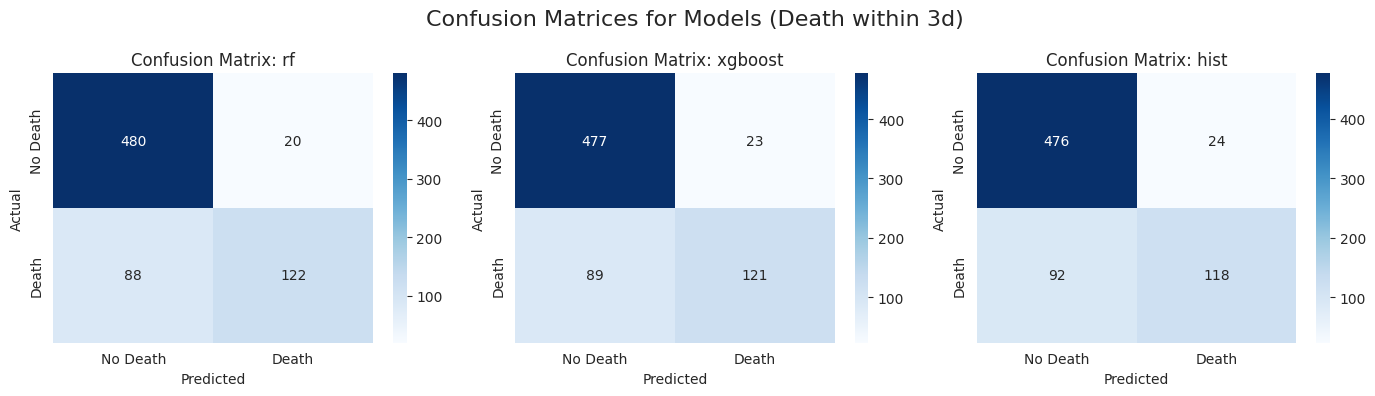

Threshold: 7


Model       AUC  Precision    Recall        F1
0       rf  0.937922   0.872973  0.863636  0.868280
1  xgboost  0.937663   0.870466  0.898396  0.884211
2     hist  0.942398   0.874016  0.890374  0.882119

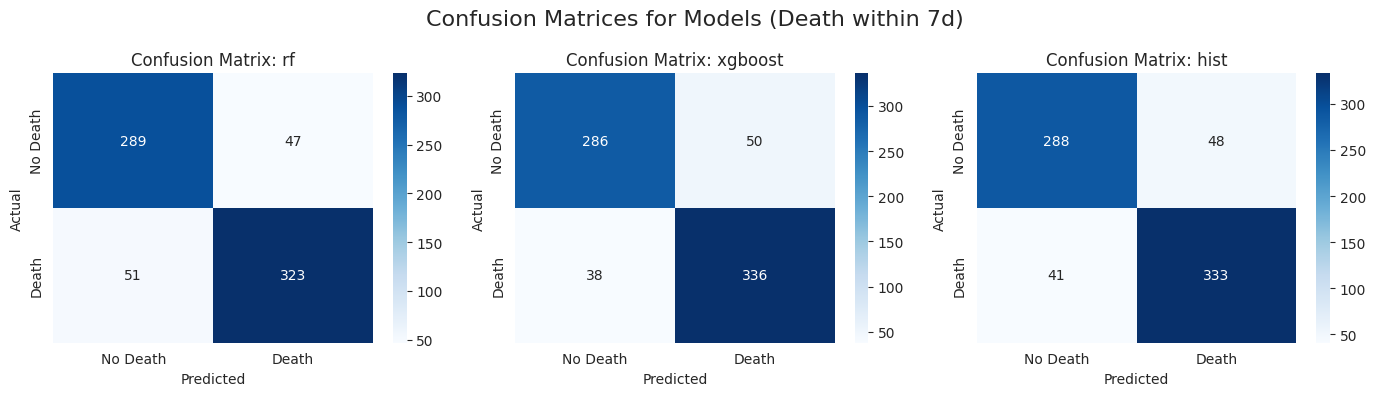

Threshold: 14


Model       AUC  Precision    Recall        F1
0       rf  0.963490   0.942164  0.931734  0.936920
1  xgboost  0.971106   0.948960  0.926199  0.937442
2     hist  0.971117   0.947170  0.926199  0.936567

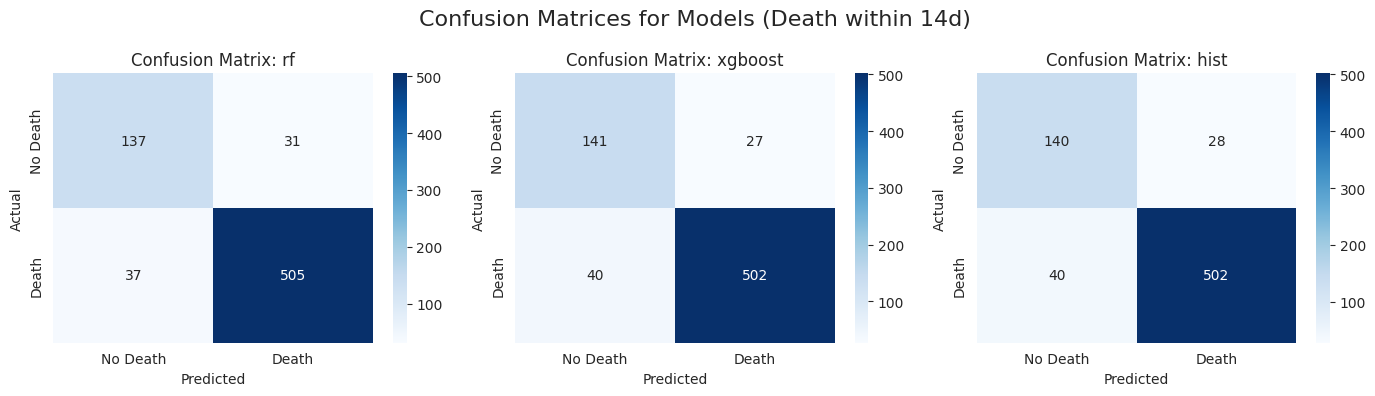

Threshold: 30


Model       AUC  Precision    Recall        F1
0       rf  0.978519   0.974513  0.989346  0.981873
1  xgboost  0.983487   0.975940  0.987823  0.981846
2     hist  0.984435   0.975976  0.989346  0.982615

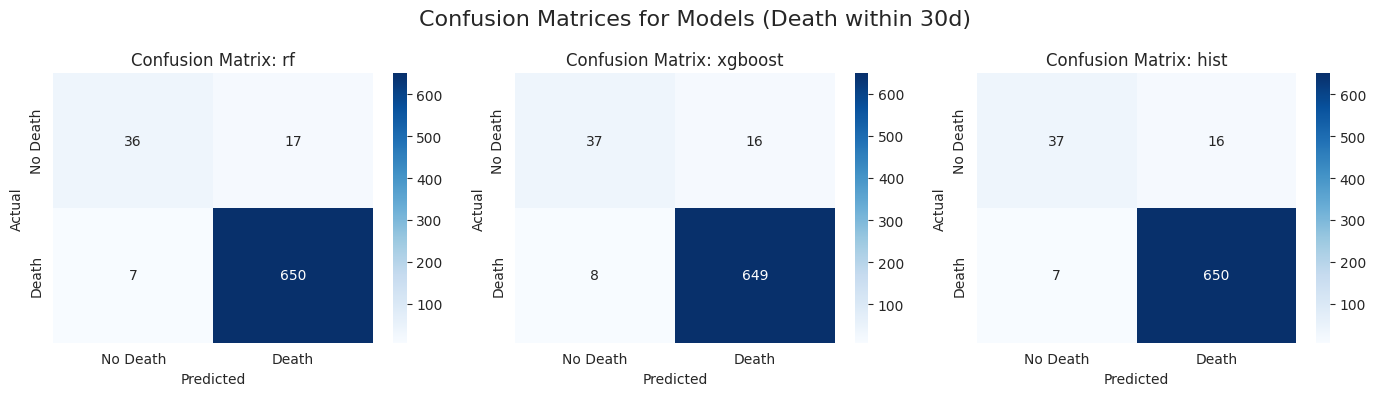

In [ ]:
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
)
def evaluate_models_clf_style(fitted_pipelines, X_train_processed, y_train, X_test, y_test, threshold=30):
    results = []

    for name, pipeline in fitted_pipelines.items():
        if name in ["dummy", "lr", "hub", ]:
            continue
        y_pred = pipeline.predict(X_test)
        y_true = y_test

        # Create binary labels: 1 = death within X days
        y_clf_true = (y_true <= threshold).astype(int)
        y_clf_pred = (y_pred <= threshold).astype(int)

        # Compute classification metrics
        auc = roc_auc_score(y_clf_true, y_pred * -1)  # Reverse because lower pred = higher death risk
        precision = precision_score(y_clf_true, y_clf_pred, zero_division=0)
        recall = recall_score(y_clf_true, y_clf_pred, zero_division=0)
        f1 = f1_score(y_clf_true, y_clf_pred, zero_division=0)
        cm = confusion_matrix(y_clf_true, y_clf_pred)

        results.append({
            'Model': name,
            'AUC': auc,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'Confusion Matrix': cm
        })

    # Convert to dataframe
    results_df = pd.DataFrame(results).drop(columns='Confusion Matrix')
    display(results_df)

    # Plot subplots for confusion matrix
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    for i, result in enumerate(results):
        sns.heatmap(result['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[i], xticklabels=['No Death', 'Death'], yticklabels=['No Death', 'Death'])
        axes[i].set_title(f'Confusion Matrix: {result["Model"]}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.suptitle(f'Confusion Matrices for Models (Death within {threshold}d)', fontsize=16)
    plt.tight_layout()
    plt.show()

for threshold in [3, 7, 14, 30]:
    print(f"Threshold: {threshold}")
    evaluate_models_clf_style(fitted_pipelines, X_train_processed, y_train, X_test_processed, y_test, threshold=threshold)

Here are some trends and insights based on the confusion matrices for the 3, 7, 14, and 30-day thresholds:
## Insights:
1. **General Trends**
   1. Models perform better at predicting deaths within longer time windows (e.g., 30 days) compared to shorter ones (e.g., 3 days). This is evident from the higher true positive (TP) and true negative (TN) counts for the 30-day threshold compared to the 3-day threshold.
   2. Shorter time windows (e.g., 3 days) result in more false negatives (FN), indicating that the models struggle to identify imminent deaths.
   3. Across all thresholds, all model show similar performance trends, with slight variations in precision and recall. `XGBoost` and `HistGradientBoosting` tend to have slightly better recall (fewer FNs) compared to `RF`, especially for shorter time windows.


2. **Threshold-Specific Insights**
   1. 30-Day Threshold: High Recall, Low False Positives`HistGradientBoosting` and `XGBoost` perform similarly, with slightly better recall than `RF`.
   2. 3-Day Threshold:- Most challenging threshold, with the highest FN counts across all models. Models prioritize precision (low FP) over recall (high FN), which may not be ideal for critical predictions like imminent death. All three models perform similarly, with no clear standout.

# Subtask 3: Model Interpretability
Apply model interpretability methods such as SHAP to explain predictions. 

In this section, we will apply feature importance first and then apply SHAP

Text(0.5, 1.0, 'Feature Importance')

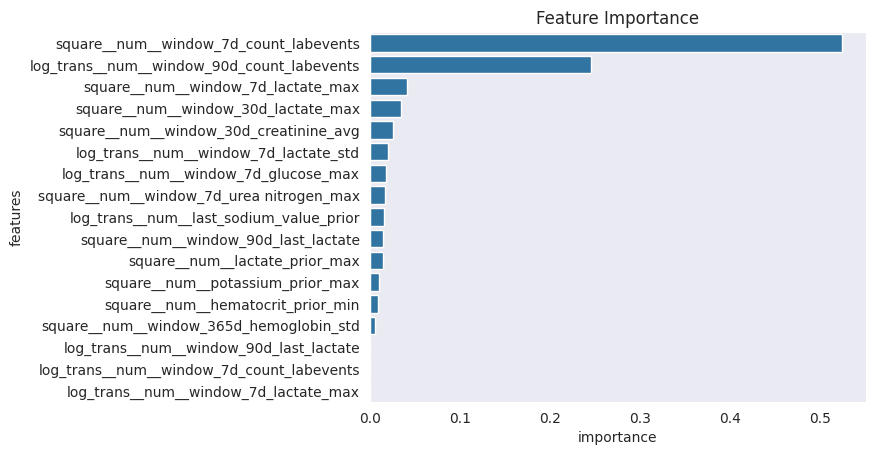

In [118]:
# Feature importance explaination

X_train_transformed = fitted_pipelines["xgboost"][:-1].transform(X_train_processed)
feat_importance = pd.DataFrame(data={
    "features" : X_train_transformed.columns,
    "importance" : fitted_pipelines["xgboost"]["model"].feature_importances_
})

sns.barplot(data = feat_importance, y = "features", x = "importance", orient="h", order=feat_importance.sort_values("importance", ascending=False)["features"])
plt.title("Feature Importance")


## Insights: Clinical Lens:

The model appears to rely heavily on:
1. Recent frequency of labs (proxy for acuity),
2. Markers of perfusion and metabolic distress (like lactate),
3. Renal and electrolyte status
4. Glucose control and hematologic trends.

These are all well-grounded in clinical literature and suggest the model is learning medically relevant signals.

1. Lab Event Counts in Recent Days: `square__num__window_7d_count_labevents`, `log_trans__num__window_90d_count_labevents`
A higher number of lab events in the last 7 or 90 days suggests clinical deterioration. Frequent testing is often triggered by clinical suspicion of worsening condition or monitoring during critical care. These counts likely serve as indirect indicators of acuity or intensity of care.<br>

2. Lactate Levels: `square__num__window_7d_lactate_max`, `square__num__window_30d_lactate_max`, `log_trans__num__window_7d_lactate_max`, `square__num__window_7d_last_lactate`
Elevated lactate is a classic marker of tissue hypoperfusion and metabolic stress, especially in sepsis or shock.

3. Creatinine and Urea Nitrogen: `square__num__window_30d_creatinine_avg`, ``square__num__window_7d_urea_nitrogen_max`. These are markers reflect renal function. Abnormal creatinine and urea levels are associated with kidney injury, which is a strong independent predictor of mortality.

4. Glucose and Hemoglobin: `log_trans__num__window_7d_glucose_max`, `square__num__window_365d_hemoglobin_std`. Extreme blood glucose levels are common in critically ill patients (due to stress hyperglycemia or diabetes) and correlate with poor outcome.

5. Electrolytes: `log_trans__num__last_sodium_value_prior`, `square__num__potassium_prior_max`

## SHAP - SHapley Additive exPlanations
We use our best model `XGBoost`

In [129]:
import shap

best_model = fitted_pipelines["xgboost"]["model"]
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [130]:
explainer = shap.TreeExplainer(model)
final_X_test = fitted_pipelines["xgboost"][:-1].transform(X_test_processed)
shap_values = explainer.shap_values(final_X_test)

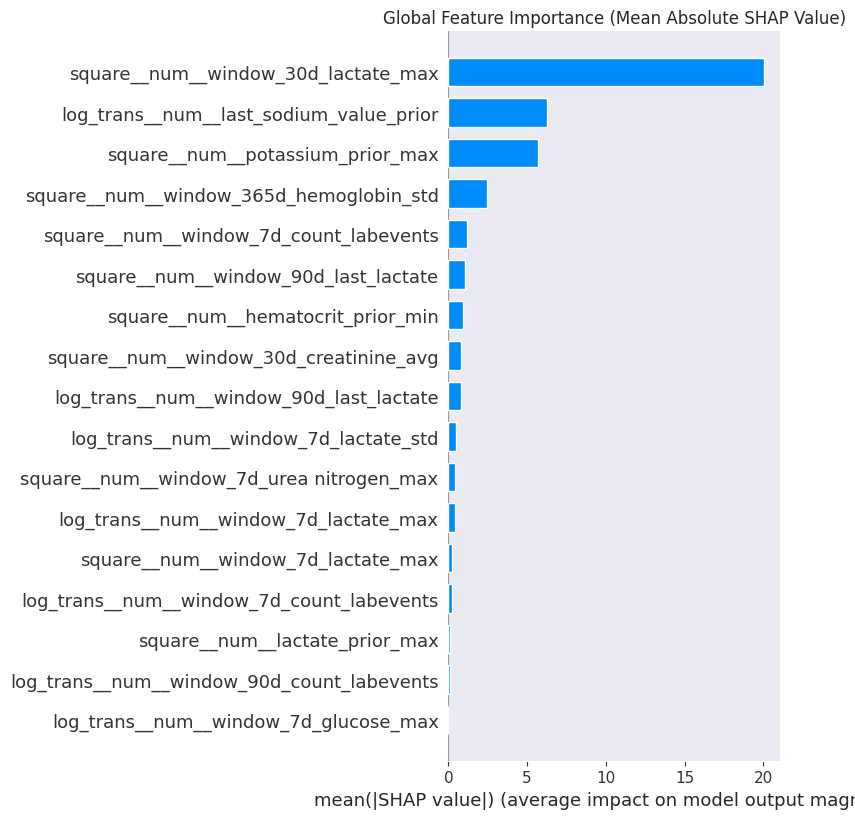

In [157]:
plt.figure()
shap.summary_plot(shap_values, final_X_test, plot_type="bar", show=False)
plt.title("Global Feature Importance (Mean Absolute SHAP Value)")
plt.tight_layout()
plt.show()

## Insight:
Similar to feature importance. Describe the maginitude od importance

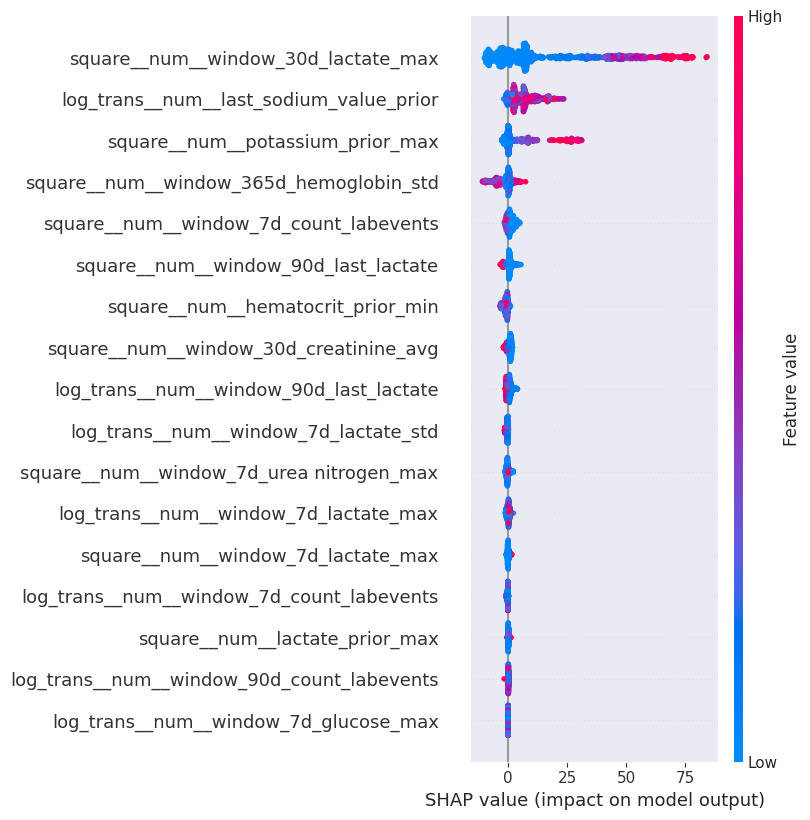

In [128]:
shap.summary_plot(shap_values, final_X_test)

## Insight: The Dot Summary Plot, describes the magnitude and direction of the important feature. 


Y-Axis: Features ranked by importance (top = most impactful).

X-Axis: SHAP value (impact on model output).
Values >0 increase the predicted risk (time to death is shorter) 
Values <0 decrease the predicted risk (time to death is longer)

Color Gradient: The actual feature value
Red = High feature value
Blue = Low feature value


1. `square__num__window_7d_count_labevents`  High count (red) ⟶ Positive SHAP (↑ risk)
    Interpretation: Patients with frequent labs in the past 7 days are likely under intensive monitoring or are deteriorating.

2. `square__num__window_30d_creatinine_avg` Higher creatinine (red) ⟶ ↑ Risk

    Interpretation: Poor kidney function in the past month correlates with higher mortality risk.

3. `log_trans__num__last_sodium_value_prior`

    Extremes of sodium (high or low) show varied impact

    Interpretation: Sodium imbalance (either hypo- or hypernatremia) affects survival, as expected.

4. `square__num__window_365d_hemoglobin_std`: High variability in hemoglobin (red) ⟶ ↑ Risk
    Interpretation: Unstable anemia or chronic condition might indicate frailty or poor baseline health.

5. Lactate-related features (e.g., lactate_max, lactate_std, lactate_prior_max): High lactate (red) consistently ⟶ ↑ SHAP
   Interpretation: High or variable lactate levels are associated with sepsis or poor perfusion, hence higher mortality.

6. `urea nitrogen_max_7d and potassium_prior_max`: High values ⟶ Positive SHAP
    Interpretation: Indicative of renal failure or electrolyte imbalance, both highly predictive of death risk.

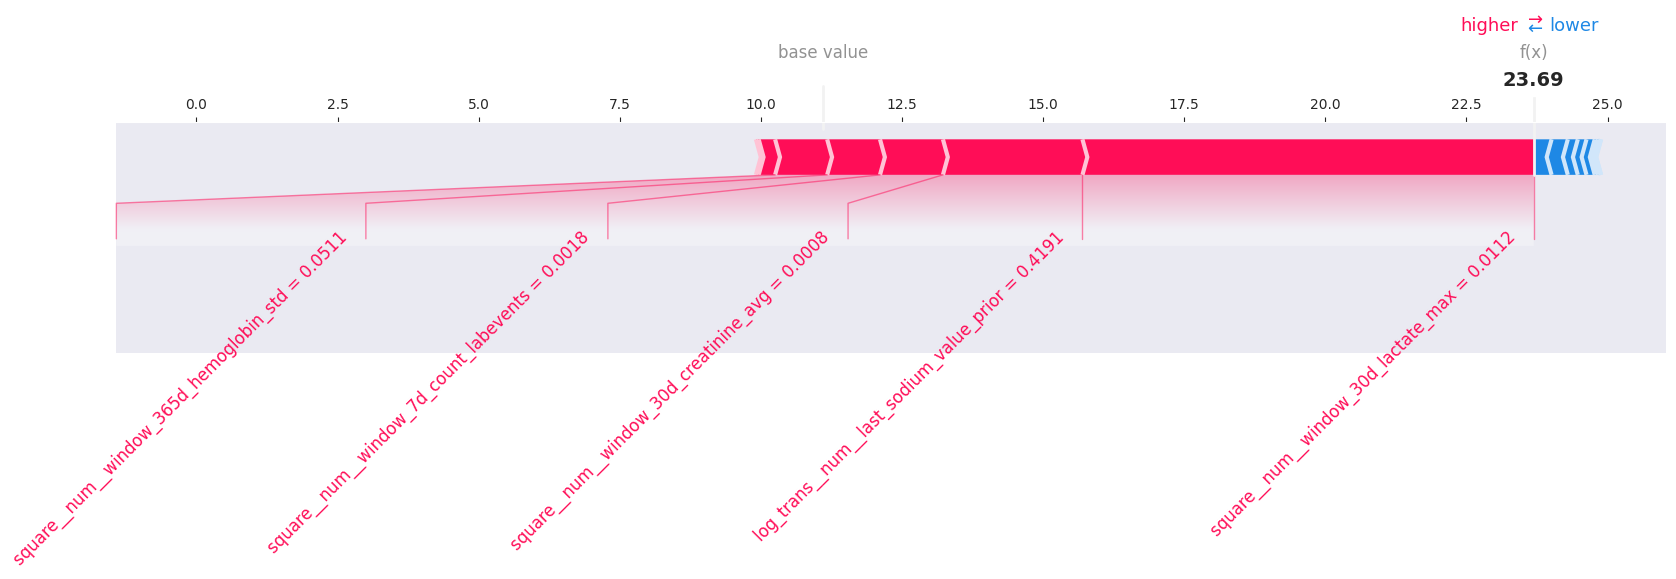

In [177]:
shap.force_plot(explainer.expected_value, shap_values[100, :], final_X_test.iloc[100, :].round(4), show=True, text_rotation=45,  matplotlib=True)
# The plot highlights the most influential factors for this specific prediction

# p = shap.force_plot(explainer.expected_value, shap_values[0,:], final_X_test.iloc[0,:])
# shap.save_html('my_force_plot.html', p)

In [178]:
final_X_test.iloc[100, :]

square__num__potassium_prior_max              0.046205
square__num__hematocrit_prior_min             0.306884
square__num__lactate_prior_max                0.021626
square__num__window_365d_hemoglobin_std       0.051092
square__num__window_90d_last_lactate          0.012519
square__num__window_30d_creatinine_avg        0.000846
square__num__window_30d_lactate_max           0.011159
square__num__window_7d_count_labevents        0.001796
square__num__window_7d_urea nitrogen_max      0.003152
square__num__window_7d_lactate_max            0.011831
log_trans__num__last_sodium_value_prior       0.419071
log_trans__num__window_90d_count_labevents    0.053062
log_trans__num__window_90d_last_lactate       0.106060
log_trans__num__window_7d_count_labevents     0.041503
log_trans__num__window_7d_glucose_max         0.069572
log_trans__num__window_7d_lactate_max         0.103253
log_trans__num__window_7d_lactate_std         0.021479
Name: 2469, dtype: float64

## Insights:
The plot highlights the most influential factors for this specific prediction.
Features shown in red push the prediction towards a longer survival time, while in blue do the opposite.

